In [1]:
# Load packages
import pickle
import pandas as pd
import numpy as np
import re, tldextract, time
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# ask about filling donation NaN with zero's?

# fill donation NaN with zero based on max years the original data set covers
# original data set goes up to 2022, so fill nan until then


In [2]:
df = pd.read_stata('FundingConfuciousFedshare.dta')

enrollment = pd.read_csv('Enrollment Data_1-3-2024.csv')



# data comes from here https://sites.ed.gov/foreigngifts/files/2023/11/Section-117_Public_Records_complete_through_2022-10-17.xlsx

In [3]:
enrollment_list = list(enrollment.columns)[2:-1]



In [4]:
enrollment_long = pd.melt(enrollment, id_vars=['UnitID','Institution Name'], value_vars=enrollment_list, var_name='year', value_name='Enrollment')

enrollment_long['year'] = enrollment_long['year'].str.replace(r'\D', '', regex=True).astype(int)



In [5]:
df.dtypes


df['contractstartdate'][1].year

contract_year=[]

for i in df['contractstartdate']:
    contract_year.append(i.year)

df['contract_year']= contract_year



In [6]:
int(df['date_opened'][3].year)






df['receipt_year'] = df['receiptdate'].dt.year
pd.set_option('display.max_columns', 500)

df['opeid'] = df['opeid'].replace(r'^\s*$', np.nan, regex=True)

df[df['opeid'].isna()]



df[df['amount']==0]

df.sort_values(['receipt_year'], ascending=[False])


df[df['receipt_year']==2022]



,opeid,schoolname,state,transactiontype,foreigngovernmentsource,attributioncountry,china,amount,receiptdate,contractstartdate,contractenddate,public,date_opened,date_closed,restrictedtransactionforeigng,l,restrictedtransactiondescripti,institutionownedbyforeignsou,foreignsourceownername,foreignsourceownershipdate,changesduetoforeignsourceow,legacydata,chinesepartner,dateopened,dateclosed,notes_dateclosed,statedreasonforclosing,r,m,t,actionpostciclosure,furtherdetails,notes,contacttitle,confuciusinstitutelink,category,statenvals,countrynvals,schoolnvals,CI,academicyear,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,meanfedshare,meangovtreliance,contract_year,receipt_year
34011,00297800,Wake Forest University,NC,Gift,No,ENGLAND,0.0,904142.0,2022-01-25,NaT,NaT,0.0,NaT,NaT,,,,No,,NaT,,No,,,,,,,,,,,,,,,0.0,0.0,1.0,0.0,2012.0,180417000.0,481043739.0,0.375053,0.395840,0.392782,0.403045,NaN,2022.0
52758,00202900,Tulane University,LA,Contract,N/A,CHINA,1.0,250000.0,2022-06-01,2018-02-04 00:00:00,2022-06-01 00:00:00,0.0,2013-01-01,2017-01-01,,,,,,NaT,,Yes,East China Normal University,1/1/2013,2017,,No stated reason.,,,,,,,,,,0.0,0.0,0.0,1.0,2012.0,152373000.0,478103000.0,0.318703,0.350312,0.300954,0.352291,2018.0,2022.0
67464,03814400,Soka University of America,CA,Gift,No,SOUTH KOREA,0.0,500000.0,2022-01-03,NaT,NaT,0.0,NaT,NaT,,,,No,,NaT,,No,,,,,,,,,,,,,,,0.0,0.0,0.0,0.0,2012.0,NaN,9283901.0,0.000000,NaN,0.001174,0.005882,NaN,2022.0


In [7]:
len(df[df['receipt_year'].notna()])- len(df[df['contract_year'].notna()])



3238

In [8]:
schools = df[['schoolname', 'state']].drop_duplicates()



years = [y for y in range(1995, 2022 + 1)]



years_df = pd.DataFrame(years)


school_years  = schools.merge(years_df, how='cross')

school_years = school_years.rename(columns={0: "year"})



df_school_year =  school_years.merge(df, how='left', left_on=['schoolname', 'state', 'year'], right_on=['schoolname', 'state', 'receipt_year'] )


df_school_year['amount']= df_school_year['amount'].fillna(0)

df_school_year['year'] = df_school_year['year'].astype(float)



#df_school_year_transactions = df_school_year[df_school_year['receipt_year'].notna()]

df_school_year['china'] = df_school_year['china'].fillna(0)

df_school_year['china_donation_bin_sum'] = df_school_year.groupby(['schoolname', 'state', 'year'])['china'].transform('sum')
# if greater than zero mean it has at least one china donatoin


df_school_year['china_donation'] = np.where(df_school_year['china_donation_bin_sum']>0, 1, 0)


df_school_year['total_foreign_donation'] = df_school_year.groupby(['schoolname', 'state', 'year'])['amount'].transform('sum')

df_school_year['mean_foreign_donation'] = df_school_year.groupby(['schoolname', 'state', 'year'])['amount'].transform('mean')

In [9]:
#df_school_year_transactions= df_school_year_transactions[['schoolname', 'state', 'year', 'china', 'total_foreign_donation','mean_foreign_donation' ,'china_donation']]



In [10]:
df_school_year[df_school_year['schoolname']=='Gill-Tech Academy of Hair Design']


df_school_year[df_school_year['schoolname']=='Lincoln University']


,schoolname,state,year,opeid,transactiontype,foreigngovernmentsource,attributioncountry,china,amount,receiptdate,contractstartdate,contractenddate,public,date_opened,date_closed,restrictedtransactionforeigng,l,restrictedtransactiondescripti,institutionownedbyforeignsou,foreignsourceownername,foreignsourceownershipdate,changesduetoforeignsourceow,legacydata,chinesepartner,dateopened,dateclosed,notes_dateclosed,statedreasonforclosing,r,m,t,actionpostciclosure,furtherdetails,notes,contacttitle,confuciusinstitutelink,category,statenvals,countrynvals,schoolnvals,CI,academicyear,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,meanfedshare,meangovtreliance,contract_year,receipt_year,china_donation_bin_sum,china_donation,total_foreign_donation,mean_foreign_donation
556,Lincoln University,MO,1995.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0
557,Lincoln University,MO,1996.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0
558,Lincoln University,MO,1997.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0
559,Lincoln University,MO,1998.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0
560,Lincoln University,MO,1999.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60454,Lincoln University,PA,2018.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0
60455,Lincoln University,PA,2019.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0
60456,Lincoln University,PA,2020.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0
60457,Lincoln University,PA,2021.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0


In [11]:
df_receipt = df_school_year.dropna(subset=['receipt_year'])
df_no_receipt = df_school_year[df_school_year['receipt_year'].isnull()]


# fix this variable by using receiptdate year
df_receipt['year_match'] = np.where(df_receipt["year"] == df_receipt["receipt_year"], True, False)

df_receipt_clean = df_receipt[df_receipt['year_match']==True] 


df_receipt_clean = df_receipt_clean.drop('year_match', axis=1)


df_donations = pd.concat([df_receipt_clean, df_no_receipt])


df_donations[df_donations['schoolname']=='Arizona State University']['year'].unique()


C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\2634958329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_receipt['year_match'] = np.where(df_receipt["year"] == df_receipt["receipt_year"], True, False)


array([2003., 2004., 2005., 2006., 2007., 2009., 2010., 2011., 2012.,
       2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021.,
       1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002., 2008.,
       2022.])

In [12]:


CI_open_year = []

CI_close_year = []

for i in df_donations['date_opened']:
    if pd.notna(i):
        CI_open_year.append(int(i.year))
    else:
        CI_open_year.append(i)
    
for i in df_donations['date_closed']:
    if pd.notna(i):
        CI_close_year.append(int(i.year))
    else:
        CI_close_year.append(i)

        
        
df_donations['CI_open_year'] = CI_open_year

df_donations['CI_close_year'] = CI_close_year


CI_open_years = []

for i, j in zip(df_donations['CI_open_year'], df_donations['CI_close_year']):
    # change code so it does if else for three variations: NAN for both lists, NAN for only close, and no NAN
    if pd.notna(i) &  pd.notna(j):
        CI_open_years.append( [y for y in range(i, j + 1)])
        # modify this code to get years for Confucius Institutes still open
    elif pd.notna(i) & pd.isna(j):
        CI_open_years.append( [y for y in range(i, 2023 + 1)])
    
    else:
        CI_open_years.append(j)





#CI variable is a bianry for if they EVER had Confucious institute
# CI_open is a binary variable for if they have a confucious institute open this year


# change CI_open_years to include years for Confucius institutes that never closed





In [13]:
#group and aggregate donations by year and university
# make each row a university year combination

df_donations['CI_open_years'] = CI_open_years

df_merged = df_donations.explode('CI_open_years')




df_merged[df_merged['schoolname']=='Arizona State University']['year'].unique()


CI_open = []

for i, j, k in zip(df_merged['CI_open_years'], df_merged['receipt_year'], df_merged['year']):
    # change code so it does if else for three variations: NAN for both lists, NAN for only close, and no NAN
    if (i == j) & (i == k) & pd.notna(i):
        CI_open.append(1)
    elif (i != j) & (i == k):
        CI_open.append(1)
    elif (i != j) & (i != k) & (j == k):
        CI_open.append(0)
    else:
        CI_open.append(i)


df_merged['CI_open'] = CI_open

df_merged[(df_merged['schoolname']=='Arizona State University')&(df_merged['year']==2009)]







,schoolname,state,year,opeid,transactiontype,foreigngovernmentsource,attributioncountry,china,amount,receiptdate,contractstartdate,contractenddate,public,date_opened,date_closed,restrictedtransactionforeigng,l,restrictedtransactiondescripti,institutionownedbyforeignsou,foreignsourceownername,foreignsourceownershipdate,changesduetoforeignsourceow,legacydata,chinesepartner,dateopened,dateclosed,notes_dateclosed,statedreasonforclosing,r,m,t,actionpostciclosure,furtherdetails,notes,contacttitle,confuciusinstitutelink,category,statenvals,countrynvals,schoolnvals,CI,academicyear,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,meanfedshare,meangovtreliance,contract_year,receipt_year,china_donation_bin_sum,china_donation,total_foreign_donation,mean_foreign_donation,CI_open_year,CI_close_year,CI_open_years,CI_open
4677,Arizona State University,AZ,2009.0,00108100,Contract,N/A,ENGLAND,0.0,285714.0,2009-02-23,2007-08-21 00:00:00,2009-10-14 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2007.0,2009.0,1.0,1,5678749.0,334044.058824,2007,2019,2007,0
4677,Arizona State University,AZ,2009.0,00108100,Contract,N/A,ENGLAND,0.0,285714.0,2009-02-23,2007-08-21 00:00:00,2009-10-14 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2007.0,2009.0,1.0,1,5678749.0,334044.058824,2007,2019,2008,0
4677,Arizona State University,AZ,2009.0,00108100,Contract,N/A,ENGLAND,0.0,285714.0,2009-02-23,2007-08-21 00:00:00,2009-10-14 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2007.0,2009.0,1.0,1,5678749.0,334044.058824,2007,2019,2009,1
4677,Arizona State University,AZ,2009.0,00108100,Contract,N/A,ENGLAND,0.0,285714.0,2009-02-23,2007-08-21 00:00:00,2009-10-14 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2007.0,2009.0,1.0,1,5678749.0,334044.058824,2007,2019,2010,0
4677,Arizona State University,AZ,2009.0,00108100,Contract,N/A,ENGLAND,0.0,285714.0,2009-02-23,2007-08-21 00:00:00,2009-10-14 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2007.0,2009.0,1.0,1,5678749.0,334044.058824,2007,2019,2011,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,Arizona State University,AZ,2009.0,00108100,Contract,N/A,ENGLAND,0.0,8838.0,2009-05-01,2008-08-21 00:00:00,2009-08-20 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22

In [14]:
df_merged[(df_merged['schoolname']=='Stanford University')]


,schoolname,state,year,opeid,transactiontype,foreigngovernmentsource,attributioncountry,china,amount,receiptdate,contractstartdate,contractenddate,public,date_opened,date_closed,restrictedtransactionforeigng,l,restrictedtransactiondescripti,institutionownedbyforeignsou,foreignsourceownername,foreignsourceownershipdate,changesduetoforeignsourceow,legacydata,chinesepartner,dateopened,dateclosed,notes_dateclosed,statedreasonforclosing,r,m,t,actionpostciclosure,furtherdetails,notes,contacttitle,confuciusinstitutelink,category,statenvals,countrynvals,schoolnvals,CI,academicyear,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,meanfedshare,meangovtreliance,contract_year,receipt_year,china_donation_bin_sum,china_donation,total_foreign_donation,mean_foreign_donation,CI_open_year,CI_close_year,CI_open_years,CI_open
36906,Stanford University,CA,1995.0,00130500,Contract,N/A,GERMANY,0.0,339712.0,1995-09-29,NaT,NaT,0.0,2013-09-27,NaT,,,,,,NaT,,Yes,Peking University,9/27/2013,,,,,,,,,,President,https://ealc.stanford.edu/confucius-institute/...,College/university,0.0,0.0,0.0,1.0,2012.0,1.035600e+09,3.673773e+09,0.28189,0.440763,0.348593,0.509992,NaN,1995.0,0.0,0,2091112.0,298730.285714,2013,NaT,2013,0
36906,Stanford University,CA,1995.0,00130500,Contract,N/A,GERMANY,0.0,339712.0,1995-09-29,NaT,NaT,0.0,2013-09-27,NaT,,,,,,NaT,,Yes,Peking University,9/27/2013,,,,,,,,,,President,https://ealc.stanford.edu/confucius-institute/...,College/university,0.0,0.0,0.0,1.0,2012.0,1.035600e+09,3.673773e+09,0.28189,0.440763,0.348593,0.509992,NaN,1995.0,0.0,0,2091112.0,298730.285714,2013,NaT,2014,0
36906,Stanford University,CA,1995.0,00130500,Contract,N/A,GERMANY,0.0,339712.0,1995-09-29,NaT,NaT,0.0,2013-09-27,NaT,,,,,,NaT,,Yes,Peking University,9/27/2013,,,,,,,,,,President,https://ealc.stanford.edu/confucius-institute/...,College/university,0.0,0.0,0.0,1.0,2012.0,1.035600e+09,3.673773e+09,0.28189,0.440763,0.348593,0.509992,NaN,1995.0,0.0,0,2091112.0,298730.285714,2013,NaT,2015,0
36906,Stanford University,CA,1995.0,00130500,Contract,N/A,GERMANY,0.0,339712.0,1995-09-29,NaT,NaT,0.0,2013-09-27,NaT,,,,,,NaT,,Yes,Peking University,9/27/2013,,,,,,,,,,President,https://ealc.stanford.edu/confucius-institute/...,College/university,0.0,0.0,0.0,1.0,2012.0,1.035600e+09,3.673773e+09,0.28189,0.440763,0.348593,0.509992,NaN,1995.0,0.0,0,2091112.0,298730.285714,2013,NaT,2016,0
36906,Stanford University,CA,1995.0,00130500,Contract,N/A,GERMANY,0.0,339712.0,1995-09-29,NaT,NaT,0.0,2013-09-27,NaT,,,,,,NaT,,Yes,Peking University,9/27/2013,,,,,,,,,,President,https://ealc.stanford.edu/confucius-institute/...,College/university,0.0,0.0,0.0,1.0,2012.0,1.035600e+09,3.673773e+09,0.28189,0.440763,0.348593,0.509992,NaN,1995.0,0.0,0,2091112.0,298730.285714,2013,NaT,2017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36915,Stanford University,CA,1998.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000,NaT,NaT,NaT,NaT
36917,Stanford University,CA,2000.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000,NaT,NaT,NaT,NaT
36918,Stanford University,CA,2001.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000,NaT,NaT,NaT,NaT
36932,Stanford University,CA,2003.0,NaN,NaN,NaN,NaN,0.0,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [15]:

df_clean = df_merged.sort_values('CI_open', ascending=False).drop_duplicates(['schoolname', 'state', 'year']).sort_index()


df_clean = df_clean.drop(columns = ['china'])

#df_clean = df_clean.merge(df_school_year_transactions, how='left', left_on=['schoolname', 'state', 'year'], right_on=['schoolname', 'state', 'year'] )





df_clean[(df_clean['schoolname']=='Arizona State University')]


,schoolname,state,year,opeid,transactiontype,foreigngovernmentsource,attributioncountry,amount,receiptdate,contractstartdate,contractenddate,public,date_opened,date_closed,restrictedtransactionforeigng,l,restrictedtransactiondescripti,institutionownedbyforeignsou,foreignsourceownername,foreignsourceownershipdate,changesduetoforeignsourceow,legacydata,chinesepartner,dateopened,dateclosed,notes_dateclosed,statedreasonforclosing,r,m,t,actionpostciclosure,furtherdetails,notes,contacttitle,confuciusinstitutelink,category,statenvals,countrynvals,schoolnvals,CI,academicyear,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,meanfedshare,meangovtreliance,contract_year,receipt_year,china_donation_bin_sum,china_donation,total_foreign_donation,mean_foreign_donation,CI_open_year,CI_close_year,CI_open_years,CI_open
4652,Arizona State University,AZ,1995.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4653,Arizona State University,AZ,1996.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4654,Arizona State University,AZ,1997.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4655,Arizona State University,AZ,1998.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4656,Arizona State University,AZ,1999.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4657,Arizona State University,AZ,2000.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4658,Arizona State University,AZ,2001.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4659,Arizona State University,AZ,2002.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4660,Arizona State University,AZ,2003.0,00108100,Contract,N/A,CHINA,820000.0,2003-09-01,2003-09-20 00:00:00,2005-10-06 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2003.0,2003.0,1.0,1,820000.0,8.200000e+05,2007,2019,2007,0
4663,Arizona State University,AZ,2004.0,00108100,Contract,N/A,KOREA,259620.0,2004-03-01,2004-04-20 00:00:00,2004-10-29 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2004.0,2004.0,0.0,0,1911538.0,6.371793e+05,2007,20

In [16]:

#df_school_year = df_school_year.drop(columns=['year'])

#df_school_year_clean =  school_years.merge(df_school_year, how='left', left_on=['schoolname', 'year'], right_on=['schoolname', 'CI_open_years'] )



In [17]:
#df_school_year_clean['CI_open'] =  (df_school_year_clean["CI_open_years"].notna()) * 1



In [18]:

# change CI_open_years to NAN for columns where receipt year does not have match with CI_open_years

In [19]:



# drop rows where academic year does not match CI_open_years


# to do this, drop all nan for CI_open_years in a seperate data frame for confucius institute universities
# also make seperate data frame with only NaN CI_open_years values
# check matches for academic year and CI_open_years in new data frame
# append two data frames back together


#df_CI = df_merged.dropna(subset=['CI_open_years'])
#df_no_CI = df_merged[df_merged['CI_open_years'].isnull()]

#df_CI['CI_open_years'] = df_CI['CI_open_years'].astype(float)

# fix this variable by using receiptdate year
#df_CI['year_match'] = np.where(df_CI["year"] == df_CI["CI_open_years"], True, False)




#df_CI_clean = df_CI[df_CI['year_match']==True] 


#df_CI_clean = df_CI_clean.drop('year_match', axis=1)

#df_clean = pd.concat([df_CI_clean, df_no_CI])

#df_clean

# fix this with outer merge

#df_clean[(df_clean['CI_open']==1) ]


#df_CI_clean[df_CI_clean['schoolname']=='Arizona State University']['year'].unique()


#df_clean = df_donations.merge(df_confucius, how='cross')




In [20]:










df_clean[df_clean['year']==1995]

df_clean[df_clean['schoolname']=='Arizona State University']






,schoolname,state,year,opeid,transactiontype,foreigngovernmentsource,attributioncountry,amount,receiptdate,contractstartdate,contractenddate,public,date_opened,date_closed,restrictedtransactionforeigng,l,restrictedtransactiondescripti,institutionownedbyforeignsou,foreignsourceownername,foreignsourceownershipdate,changesduetoforeignsourceow,legacydata,chinesepartner,dateopened,dateclosed,notes_dateclosed,statedreasonforclosing,r,m,t,actionpostciclosure,furtherdetails,notes,contacttitle,confuciusinstitutelink,category,statenvals,countrynvals,schoolnvals,CI,academicyear,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,meanfedshare,meangovtreliance,contract_year,receipt_year,china_donation_bin_sum,china_donation,total_foreign_donation,mean_foreign_donation,CI_open_year,CI_close_year,CI_open_years,CI_open
4652,Arizona State University,AZ,1995.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4653,Arizona State University,AZ,1996.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4654,Arizona State University,AZ,1997.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4655,Arizona State University,AZ,1998.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4656,Arizona State University,AZ,1999.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4657,Arizona State University,AZ,2000.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4658,Arizona State University,AZ,2001.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4659,Arizona State University,AZ,2002.0,NaN,NaN,NaN,NaN,0.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.000000e+00,NaT,NaT,NaT,NaT
4660,Arizona State University,AZ,2003.0,00108100,Contract,N/A,CHINA,820000.0,2003-09-01,2003-09-20 00:00:00,2005-10-06 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2003.0,2003.0,1.0,1,820000.0,8.200000e+05,2007,2019,2007,0
4663,Arizona State University,AZ,2004.0,00108100,Contract,N/A,KOREA,259620.0,2004-03-01,2004-04-20 00:00:00,2004-10-29 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2004.0,2004.0,0.0,0,1911538.0,6.371793e+05,2007,20

In [21]:



# make variable for total china donation


df_china_donations = df_school_year[df_school_year['china']==1]

df_china_donations['total_china_donation'] = df_china_donations.groupby(['schoolname', 'state', 'year'])['amount'].transform('sum')



df_china_donations['mean_china_donation'] = df_china_donations.groupby(['schoolname', 'state', 'year', 'china'])['amount'].transform('mean')

# combine china donation data frame back to clean data frame to get china stats


df_china_donations_filtered = df_china_donations[['schoolname', 'state', 'year', 'total_china_donation','mean_china_donation']]


master_df = df_clean.drop_duplicates(subset=['schoolname', 'state', 'year'], keep="first")



master_df = master_df.merge(df_china_donations_filtered, how = 'left', on = ['schoolname', 'state', 'year'])

master_df['mean_fed_share'] = master_df.groupby(['schoolname', 'state', 'receipt_year'])['federal_share'].transform('mean')

master_df[(master_df['CI_open_years'].isna())&(master_df['receipt_year'].notna())]




df_china_donations[df_china_donations['schoolname']=="Arizona State University"]





C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\3653325526.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_china_donations['total_china_donation'] = df_china_donations.groupby(['schoolname', 'state', 'year'])['amount'].transform('sum')
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\3653325526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_china_donations['mean_china_donation'] = df_china_donations.groupby(['schoolname', 'state', 'year', 'china'])['amount'].transform('mean')


,schoolname,state,year,opeid,transactiontype,foreigngovernmentsource,attributioncountry,china,amount,receiptdate,contractstartdate,contractenddate,public,date_opened,date_closed,restrictedtransactionforeigng,l,restrictedtransactiondescripti,institutionownedbyforeignsou,foreignsourceownername,foreignsourceownershipdate,changesduetoforeignsourceow,legacydata,chinesepartner,dateopened,dateclosed,notes_dateclosed,statedreasonforclosing,r,m,t,actionpostciclosure,furtherdetails,notes,contacttitle,confuciusinstitutelink,category,statenvals,countrynvals,schoolnvals,CI,academicyear,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,meanfedshare,meangovtreliance,contract_year,receipt_year,china_donation_bin_sum,china_donation,total_foreign_donation,mean_foreign_donation,total_china_donation,mean_china_donation
4660,Arizona State University,AZ,2003.0,00108100,Contract,N/A,CHINA,1.0,820000.0,2003-09-01,2003-09-20 00:00:00,2005-10-06 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2003.0,2003.0,1.0,1,820000.0,820000.000000,820000.0,820000.0
4665,Arizona State University,AZ,2006.0,00108100,Contract,N/A,CHINA,1.0,470000.0,2006-02-01,2005-08-13 00:00:00,2007-07-01 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2005.0,2006.0,2.0,1,2446330.0,271814.444444,890000.0,445000.0
4672,Arizona State University,AZ,2006.0,00108100,Contract,N/A,CHINA,1.0,420000.0,2006-02-01,2004-07-23 00:00:00,2006-09-30 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2004.0,2006.0,2.0,1,2446330.0,271814.444444,890000.0,445000.0
4674,Arizona State University,AZ,2007.0,00108100,Contract,N/A,CHINA,1.0,470000.0,2007-03-28,2005-08-13 00:00:00,2007-07-01 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2005.0,2007.0,2.0,1,896000.0,448000.000000,896000.0,448000.0
4675,Arizona State University,AZ,2007.0,00108100,Contract,N/A,CHINA,1.0,426000.0,2007-03-28,2006-07-08 00:00:00,2008-08-31 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent legislation enacted by the Unite...,,M,,Maintained “sister university” relationship wi...,See case study section in After Confucius Ins...,,,http://confuciusinstitute.asu.edu,,0.0,0.0,0.0,1.0,2012.0,340525000.0,1.425610e+09,0.238863,0.434615,0.186986,0.599009,2006.0,2007.0,2.0,1,896000.0,448000.000000,896000.0,448000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119,Arizona State University,AZ,2019.0,00108100,Contract,N/A,CHINA,1.0,188.0,2019-11-14,2017-03-31 00:00:00,2021-03-31 00:00:00,1.0,2007-10-22,2019-05-01,,,,,,NaT,,Yes,Sichuan University,10/22/2007,5/2019,,“Given recent

In [22]:
constants = df

constants = constants[['schoolname', 'state', 'public', 'federal10', 'tot_rev_wo_auxother_sum', 'r', 'federal_share',  'govt_reliance_a']]

constants = constants.drop_duplicates()


constants[constants['schoolname']=='Lincoln University']





,schoolname,state,public,federal10,tot_rev_wo_auxother_sum,r,federal_share,govt_reliance_a
1,Lincoln University,MO,1.0,22476659.0,47132426.0,,0.476883,0.681375
2,Lincoln University,CA,1.0,141250.0,3330369.0,,0.042413,NaN
22169,Lincoln University,PA,1.0,NaN,NaN,,NaN,NaN


In [23]:
df[(df['schoolname']== 'Columbia College')&(df['state']== 'MO')]



,opeid,schoolname,state,transactiontype,foreigngovernmentsource,attributioncountry,china,amount,receiptdate,contractstartdate,contractenddate,public,date_opened,date_closed,restrictedtransactionforeigng,l,restrictedtransactiondescripti,institutionownedbyforeignsou,foreignsourceownername,foreignsourceownershipdate,changesduetoforeignsourceow,legacydata,chinesepartner,dateopened,dateclosed,notes_dateclosed,statedreasonforclosing,r,m,t,actionpostciclosure,furtherdetails,notes,contacttitle,confuciusinstitutelink,category,statenvals,countrynvals,schoolnvals,CI,academicyear,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,meanfedshare,meangovtreliance,contract_year,receipt_year
15906,00245600,Columbia College,MO,Gift,N/A,HONG KONG,0.0,250000.0,1999-10-12,NaT,NaT,0.0,NaT,NaT,,,,,,NaT,,Yes,,,,,,,,,,,,,,,0.0,0.0,1.0,0.0,2012.0,1084088.0,98256778.0,0.011033,0.011135,0.080244,0.310541,NaN,1999.0
23845,00245600,Columbia College,MO,Gift,N/A,IRELAND,0.0,256467.0,1999-11-11,NaT,NaT,0.0,NaT,NaT,,,,,,NaT,,Yes,,,,,,,,,,,,,,,0.0,0.0,0.0,0.0,2012.0,1084088.0,98256778.0,0.011033,0.011135,0.080244,0.310541,NaN,1999.0
62681,00245600,Columbia College,MO,Gift,N/A,FRANCE,0.0,336995.0,1999-10-05,NaT,NaT,0.0,NaT,NaT,,,,,,NaT,,Yes,,,,,,,,,,,,,,,0.0,0.0,0.0,0.0,2012.0,1084088.0,98256778.0,0.011033,0.011135,0.080244,0.310541,NaN,1999.0


In [24]:
master_df = master_df[['schoolname', 'state',  'year', 'CI', 'CI_open', 'china_donation', 'total_foreign_donation', 'mean_foreign_donation','total_china_donation', 'mean_china_donation']]




master_df =  master_df.merge(constants, how='left', left_on=['schoolname', 'state'], right_on=['schoolname', 'state'] )




In [25]:
master_df[master_df['schoolname']=='Alabama A&M University']


master_df[master_df['schoolname']=="Saint John's University"]



zero_china_donation = master_df[master_df['total_foreign_donation'].notna()]

zero_china_donation['total_china_donation'] = zero_china_donation['total_china_donation'].fillna(0)

zero_china_donation['mean_china_donation'] = zero_china_donation['mean_china_donation'].fillna(0)

zero_china_donation=zero_china_donation[['schoolname', 'state', 'year', 'total_china_donation','mean_china_donation']]

master_df = master_df.drop(columns = ['total_china_donation','mean_china_donation'])


master_df = master_df.merge(zero_china_donation, how='left', left_on=['schoolname', 'state', 'year'], right_on=['schoolname', 'state', 'year'] )



In [26]:
master_df[master_df['schoolname']=='Arizona State University']




,schoolname,state,year,CI,CI_open,china_donation,total_foreign_donation,mean_foreign_donation,public,federal10,tot_rev_wo_auxother_sum,r,federal_share,govt_reliance_a,total_china_donation,mean_china_donation
10387,Arizona State University,AZ,1995.0,NaN,NaT,0,0.0,0.000000,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,0.0,0.0
10388,Arizona State University,AZ,1996.0,NaN,NaT,0,0.0,0.000000,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,0.0,0.0
10389,Arizona State University,AZ,1997.0,NaN,NaT,0,0.0,0.000000,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,0.0,0.0
10390,Arizona State University,AZ,1998.0,NaN,NaT,0,0.0,0.000000,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,0.0,0.0
10391,Arizona State University,AZ,1999.0,NaN,NaT,0,0.0,0.000000,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10982,Arizona State University,AZ,2019.0,1.0,1,1,28645146.0,502546.421053,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,9117330.0,759777.5
10983,Arizona State University,AZ,2019.0,1.0,1,1,28645146.0,502546.421053,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,9117330.0,759777.5
10984,Arizona State University,AZ,2020.0,1.0,0,0,5249345.5,437445.458333,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,0.0,0.0
10985,Arizona State University,AZ,2021.0,1.0,0,0,4190357.3,419035.730000,1.0,340525000.0,1.425610e+09,,0.238863,0.434615,0.0,0.0


In [27]:


master_df = master_df.sort_values(by=['schoolname', 'state', 'year'])




master_df['schoolname'] = master_df['schoolname'].astype(str)



master_df['state'] = master_df['state'].astype(str)

master_df['CI_open'] = master_df['CI_open'].astype(str)


master_df = master_df.drop_duplicates(subset=['schoolname', 'state', 'year'], keep="first")



master_df


,schoolname,state,year,CI,CI_open,china_donation,total_foreign_donation,mean_foreign_donation,public,federal10,tot_rev_wo_auxother_sum,r,federal_share,govt_reliance_a,total_china_donation,mean_china_donation
118717,Adelphi University,NY,1995.0,NaN,NaT,0,0.0,0.0,0.0,1895542.0,183775695.0,,0.010314,0.024485,0.0,0.0
118718,Adelphi University,NY,1996.0,NaN,NaT,0,0.0,0.0,0.0,1895542.0,183775695.0,,0.010314,0.024485,0.0,0.0
118719,Adelphi University,NY,1997.0,NaN,NaT,0,0.0,0.0,0.0,1895542.0,183775695.0,,0.010314,0.024485,0.0,0.0
118720,Adelphi University,NY,1998.0,NaN,NaT,0,0.0,0.0,0.0,1895542.0,183775695.0,,0.010314,0.024485,0.0,0.0
118721,Adelphi University,NY,1999.0,NaN,NaT,0,0.0,0.0,0.0,1895542.0,183775695.0,,0.010314,0.024485,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11186,Young Americans College of the Performing Arts...,CA,2018.0,NaN,NaT,0,0.0,0.0,0.0,NaN,NaN,,NaN,NaN,0.0,0.0
11187,Young Americans College of the Performing Arts...,CA,2019.0,0.0,0,0,421583.0,421583.0,0.0,NaN,NaN,,NaN,NaN,0.0,0.0
11188,Young Americans College of the Performing Arts...,CA,2020.0,0.0,0,0,700000.0,700000.0,0.0,NaN,NaN,,NaN,NaN,0.0,0.0
11189,Young Americans College of the Performing Arts...,CA,2021.0,NaN,NaT,0,0.0,0.0,0.0,NaN,NaN,,NaN,NaN,0.0,0.0


In [28]:
master_df[master_df['schoolname']=="Arizona State University"]

transition= df_donations
transition['CI_open_years']= CI_open_years

transition = transition[transition['CI_open_years'].notna()]

transition = transition[['schoolname', 'state', 'CI_open_years']]


transition = transition.explode('CI_open_years')


transition['CI_open']= 1



master_df_clean = master_df.drop(columns=['CI_open'])


master_df_clean = master_df_clean.merge(transition, how = 'left',  left_on=['schoolname', 'state', 'year'], right_on=['schoolname', 'state', 'CI_open_years'])


master_df_clean = master_df_clean.drop_duplicates()


master_df_clean['CI_open'] = master_df_clean['CI_open'].fillna(0)



 
master_df_clean = master_df_clean.rename(columns={'CI': "CI_ever"})


master_df_clean['CI_open'] = master_df_clean['CI_open'].astype(int)


master_df_clean['year'] = master_df_clean['year'].astype(int)



master_df_clean['CI_ever'] = master_df_clean.groupby(['schoolname', 'state'])['CI_ever'].fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)


total_foreign_donation = []

for i, j in zip(master_df_clean['total_foreign_donation'], master_df_clean['mean_foreign_donation']):
    if pd.isna(j):
        total_foreign_donation.append(np.nan)
    else:
        total_foreign_donation.append(i)


master_df_clean = master_df_clean.drop(columns=['total_foreign_donation'])
master_df_clean['total_foreign_donation'] = total_foreign_donation

master_df_clean = master_df_clean[['schoolname', 'state',  'public', 'year', 'CI_ever', 'CI_open', 'r', 'china_donation', 'federal10', 'tot_rev_wo_auxother_sum', 'federal_share', 'govt_reliance_a',  'total_foreign_donation', 'mean_foreign_donation','total_china_donation', 'mean_china_donation']]










In [29]:

# write up data description 
# make sure there are no sampling problems. Count number of private 
# look at characteristics for universities that take tons of China money that didn't set up a CI

In [30]:
CI_survival_years = master_df_clean[master_df_clean['CI_open']==1]




CI_survival_years['CI_survival_years'] = CI_survival_years.groupby(['schoolname', 'state'])['CI_open'].cumsum()
CI_survival_years = CI_survival_years[['schoolname', 'state', 'year', 'CI_survival_years']]


master_df_clean = master_df_clean.merge(CI_survival_years, how = 'left',  left_on=['schoolname', 'state', 'year'], right_on=['schoolname', 'state', 'year'])


# CI institute survival by years

No_CI_years = master_df_clean[master_df_clean['CI_open']==0]


No_CI_years['No_CI_True'] = 1

No_CI_years['No_CI_years'] = No_CI_years.groupby(['schoolname', 'state'])['No_CI_True'].cumsum()
No_CI_years = No_CI_years[['schoolname', 'state', 'year', 'No_CI_years']]


master_df_clean = master_df_clean.merge(No_CI_years, how = 'left',  left_on=['schoolname', 'state', 'year'], right_on=['schoolname', 'state', 'year'])




C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\2755284571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CI_survival_years['CI_survival_years'] = CI_survival_years.groupby(['schoolname', 'state'])['CI_open'].cumsum()
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\2755284571.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  No_CI_years['No_CI_True'] = 1
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\2755284571.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [31]:
master_df_clean[master_df_clean['schoolname']=='Arizona State University']

,schoolname,state,public,year,CI_ever,CI_open,r,china_donation,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,total_foreign_donation,mean_foreign_donation,total_china_donation,mean_china_donation,CI_survival_years,No_CI_years
196,Arizona State University,AZ,1.0,1995,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00,NaN,1.0
197,Arizona State University,AZ,1.0,1996,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00,NaN,2.0
198,Arizona State University,AZ,1.0,1997,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00,NaN,3.0
199,Arizona State University,AZ,1.0,1998,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00,NaN,4.0
200,Arizona State University,AZ,1.0,1999,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00,NaN,5.0
201,Arizona State University,AZ,1.0,2000,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00,NaN,6.0
202,Arizona State University,AZ,1.0,2001,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00,NaN,7.0
203,Arizona State University,AZ,1.0,2002,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00,NaN,8.0
204,Arizona State University,AZ,1.0,2003,1.0,0,,1,340525000.0,1.425610e+09,0.238863,0.434615,820000.0,8.200000e+05,820000.0,8.200000e+05,NaN,9.0
205,Arizona State University,AZ,1.0,2004,1.0,0,,0,340525000.0,1.425610e+09,0.238863,0.434615,1911538.0,6.371793e+05,0.0,0.000000e+00,NaN,10.0


In [32]:

# create variable for survival analysis

In [33]:

master_df_clean[master_df_clean['schoolname']=='Alabama A&M University']


master_df_clean[master_df_clean['schoolname']=='Alabama A&M University']



constants

master_df_clean[master_df_clean['schoolname']=="Saint John's University"]

constants[constants['schoolname']=="Saint John's University"]



,schoolname,state,public,federal10,tot_rev_wo_auxother_sum,r,federal_share,govt_reliance_a
0,Saint John's University,NY,0.0,NaN,NaN,,NaN,NaN
47026,Saint John's University,MN,0.0,NaN,NaN,,NaN,NaN


In [34]:
master_df_clean[master_df_clean['schoolname']=='Arizona State University']

duplicate_rows = master_df_clean[master_df_clean.duplicated()]


master_df_clean[master_df_clean['total_foreign_donation']==0]

df[df['schoolname']=='Gill-Tech Academy of Hair Design']






len(master_df_clean[master_df_clean['schoolname']=='Arizona State University'])




master_df_clean[master_df_clean['schoolname']=="Saint John's University"]


master_df_clean[master_df_clean['schoolname']=='Columbia College']



,schoolname,state,public,year,CI_ever,CI_open,r,china_donation,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,total_foreign_donation,mean_foreign_donation,total_china_donation,mean_china_donation,CI_survival_years,No_CI_years
2548,Columbia College,CA,0.0,1995,1.0,0,,0,38719349.0,115963376.0,0.333893,0.839690,0.0,0.0,0.0,0.0,NaN,1.0
2549,Columbia College,CA,0.0,1996,1.0,0,,0,38719349.0,115963376.0,0.333893,0.839690,0.0,0.0,0.0,0.0,NaN,2.0
2550,Columbia College,CA,0.0,1997,1.0,0,,0,38719349.0,115963376.0,0.333893,0.839690,0.0,0.0,0.0,0.0,NaN,3.0
2551,Columbia College,CA,0.0,1998,1.0,0,,0,38719349.0,115963376.0,0.333893,0.839690,0.0,0.0,0.0,0.0,NaN,4.0
2552,Columbia College,CA,0.0,1999,1.0,0,,0,38719349.0,115963376.0,0.333893,0.839690,0.0,0.0,0.0,0.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,Columbia College,VA,0.0,2018,0.0,0,,0,763569.0,1228689.0,0.621450,0.137033,0.0,0.0,0.0,0.0,NaN,24.0
2656,Columbia College,VA,0.0,2019,0.0,0,,0,763569.0,1228689.0,0.621450,0.137033,0.0,0.0,0.0,0.0,NaN,25.0
2657,Columbia College,VA,0.0,2020,0.0,0,,0,763569.0,1228689.0,0.621450,0.137033,0.0,0.0,0.0,0.0,NaN,26.0
2658,Columbia College,VA,0.0,2021,0.0,0,,0,763569.0,1228689.0,0.621450,0.137033,0.0,0.0,0.0,0.0,NaN,27.0


In [35]:
from collections import Counter



master_df_clean[master_df_clean['schoolname'].isin(['Columbia College','Lincoln University', 'Bryant & Stratton Colleg','MBTI Business Training Institute', "Saint John's University"])]

master_df_clean[master_df_clean['schoolname']=="Saint John's University"]
df[df['schoolname']=="Saint John's University"]


master_df_clean['university_state'] = master_df_clean['schoolname']+ '_'+master_df_clean['state']


master_df_clean = master_df_clean[['university_state', 'schoolname', 'state',  'public', 'year', 'CI_ever', 'CI_open', 'No_CI_years', 'CI_survival_years', 'r', 'china_donation', 'federal10', 'tot_rev_wo_auxother_sum', 'federal_share', 'govt_reliance_a',  'total_foreign_donation', 'mean_foreign_donation','total_china_donation', 'mean_china_donation']]






In [36]:

len(master_df_clean['schoolname'].unique())

540

In [37]:
master_df_clean[master_df_clean['schoolname']=='Arizona State University']

master_df_clean[master_df_clean['schoolname']=='Gill-Tech Academy of Hair Design']

# change code so that it automates output of graphs
master_df_clean[master_df_clean['schoolname']=='Georgetown University']

master_df_clean[master_df_clean['schoolname']=='Arizona State University']



,university_state,schoolname,state,public,year,CI_ever,CI_open,No_CI_years,CI_survival_years,r,china_donation,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,total_foreign_donation,mean_foreign_donation,total_china_donation,mean_china_donation
196,Arizona State University_AZ,Arizona State University,AZ,1.0,1995,1.0,0,1.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00
197,Arizona State University_AZ,Arizona State University,AZ,1.0,1996,1.0,0,2.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00
198,Arizona State University_AZ,Arizona State University,AZ,1.0,1997,1.0,0,3.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00
199,Arizona State University_AZ,Arizona State University,AZ,1.0,1998,1.0,0,4.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00
200,Arizona State University_AZ,Arizona State University,AZ,1.0,1999,1.0,0,5.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00
201,Arizona State University_AZ,Arizona State University,AZ,1.0,2000,1.0,0,6.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00
202,Arizona State University_AZ,Arizona State University,AZ,1.0,2001,1.0,0,7.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00
203,Arizona State University_AZ,Arizona State University,AZ,1.0,2002,1.0,0,8.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,0.0,0.000000e+00,0.0,0.000000e+00
204,Arizona State University_AZ,Arizona State University,AZ,1.0,2003,1.0,0,9.0,NaN,,1,340525000.0,1.425610e+09,0.238863,0.434615,820000.0,8.200000e+05,820000.0,8.200000e+05
205,Arizona State University_AZ,Arizona State University,AZ,1.0,2004,1.0,0,10.0,NaN,,0,340525000.0,1.425610e+09,0.238863,0.434615,1911538.0,6.371793e+05,0.0,0.000000e+00


In [38]:
master_df_clean[master_df_clean['schoolname']=='Columbia College']['university_state'].unique()
master_df_clean[master_df_clean['schoolname']=='Lincoln University']['university_state'].unique()
master_df_clean[master_df_clean['schoolname']=='Bryant & Stratton College']['university_state'].unique()
master_df_clean[master_df_clean['schoolname']=='MBTI Business Training Institute']['university_state'].unique()
master_df_clean[master_df_clean['schoolname']=='Marian University']['university_state'].unique()


Counter(list(master_df_clean['schoolname']))


master_df_clean[master_df_clean['schoolname']=="Saint John's University"]['university_state'].unique()



array(["Saint John's University_MN", "Saint John's University_NY"],
      dtype=object)

In [39]:
empty_university_with_error = df[df['CI'].isna()][['schoolname', 'state']]

empty_university_with_error['university_state'] = empty_university_with_error['schoolname']+'_'+empty_university_with_error['state']

empty_university_with_error = list(empty_university_with_error['university_state'])



In [40]:
master_df_clean[master_df_clean['schoolname']=='Columbia College']['university_state'].unique()

public = ['Columbia College_CA', 'Lincoln University_MO', 'Lincoln University_PA']

private = ['Columbia College_MO', 'Columbia College_SC', 'Columbia College_VA', 'Lincoln University_CA', 'Bryant & Stratton College_NY', 'Bryant & Stratton College_OH', 'MBTI Business Training Institute_PR', 'MBTI Business Training Institute_WI', 'Marian University_IN', 'Marian University_WI', "Saint John's University_MN","Saint John's University_NY" ]


master_df_clean.loc[(master_df_clean['university_state'].isin(public)), 'public'] = 1

master_df_clean.loc[(master_df_clean['university_state'].isin(private)), 'public'] = 0


master_df_clean[master_df_clean['university_state']== 'Lincoln University_CA']



master_df_clean = master_df_clean[~master_df_clean["university_state"].isin(empty_university_with_error)]




In [41]:
demographics = pd.read_excel('tabn310.20.xlsx')

In [42]:
demographics.dtypes

demographics[demographics.columns[0]]

ind_list = [0, 3, 12]
demographics = demographics.iloc[ind_list].dropna(axis=1)
demographics.columns = demographics.iloc[0]

demographics= demographics.iloc[1: , :]

demographics_china= demographics.iloc[1: , :]

demographics_total = demographics.drop([12],axis=0)

demographics_china_long = demographics_china.melt()

demographics_total_long = demographics_total.melt()

demographics_china_long.columns = demographics_china_long.iloc[0]

demographics_total_long.columns = demographics_total_long.iloc[0]

demographics_china_long= demographics_china_long.iloc[1: , :]


demographics_total_long= demographics_total_long.iloc[1: , :]

demographics_china_long = demographics_china_long.rename(columns={"Continent, region, and selected countries of origin": "demographic_years", '    China': "china_students_in_USA"})


demographics_total_long = demographics_total_long.rename(columns={"Continent, region, and selected countries of origin": "demographic_years", '     Total ' : "total_foreign_students"})




In [43]:
demographics_clean = demographics_china_long.merge(demographics_total_long)

demographics_clean['china_student_percent'] = (demographics_clean['china_students_in_USA']/demographics_clean['total_foreign_students'])*100

start_school_year= []

end_school_year= []

for i in demographics_clean['demographic_years']:
    start_school_year.append(int(i[0:4]))
    end_school_year.append(int(i[0:2]+i[5:7]))

demographics_clean['year'] = start_school_year

demographics_clean['end_school_year'] = end_school_year

# add total foreign

demographics_for_merge = demographics_clean[['year', 'china_students_in_USA', 'total_foreign_students', 'china_student_percent']]

demographics_for_merge

,year,china_students_in_USA,total_foreign_students,china_student_percent
0,1980,2770,311880,0.888162
1,1985,13980,343780,4.066554
2,1990,39597,407272,9.722495
3,1995,39613,453787,8.729426
4,2000,59939,547873,10.940309
5,2005,62582,564766,11.081049
6,2010,157558,723249,21.784752
7,2015,328547,1043839,31.474873
8,2020,317299,914095,34.711819
9,2021,290086,948519,30.583046


In [44]:
master_df_clean = master_df_clean.merge(demographics_for_merge, how='left', left_on=['year'], right_on=['year'])


master_df_clean['china_students_in_USA'] = master_df_clean['china_students_in_USA'].astype(float)
master_df_clean['total_foreign_students'] = master_df_clean['total_foreign_students'].astype(float)
master_df_clean['china_student_percent'] = master_df_clean['china_student_percent'].astype(float)



In [45]:
master_df_clean['china_donation_proportion']= master_df_clean['total_china_donation']/master_df_clean['tot_rev_wo_auxother_sum']


master_df_clean['china_donation_over_federal']= master_df_clean['total_china_donation']/master_df_clean['federal10']



In [46]:
# create cumulative china donation variable

master_df_clean['cumulative_china_donations'] = master_df_clean.groupby('university_state')['total_china_donation'].cumsum()


master_df_clean[master_df_clean['schoolname']=='University of Arizona (The)']

,university_state,schoolname,state,public,year,CI_ever,CI_open,No_CI_years,CI_survival_years,r,china_donation,federal10,tot_rev_wo_auxother_sum,federal_share,govt_reliance_a,total_foreign_donation,mean_foreign_donation,total_china_donation,mean_china_donation,china_students_in_USA,total_foreign_students,china_student_percent,china_donation_proportion,china_donation_over_federal,cumulative_china_donations
10024,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,1995,1.0,0,1.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,39613.0,453787.0,8.729426,0.000000,0.000000,0.0
10025,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,1996,1.0,0,2.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.0
10026,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,1997,1.0,0,3.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.0
10027,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,1998,1.0,0,4.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.0
10028,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,1999,1.0,0,5.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.0
10029,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,2000,1.0,0,6.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,59939.0,547873.0,10.940309,0.000000,0.000000,0.0
10030,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,2001,1.0,0,7.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.0
10031,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,2002,1.0,0,8.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,300000.0,3.000000e+05,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.0
10032,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,2003,1.0,0,9.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.0
10033,University of Arizona (The)_AZ,University of Arizona (The),AZ,1.0,2004,1.0,0,10.0,NaN,,0,439754000.0,1.305967e+09,0.336727,0.616703,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.0


In [47]:


master_df_enroll = master_df_clean.merge(enrollment_long, how='left', left_on=['schoolname', 'year'], right_on=['Institution Name','year'])



In [48]:





initial_data = master_df_enroll[['UnitID','university_state', 'schoolname', 'year', 'CI_open',  'public', 'Enrollment', 'federal_share' , 'total_foreign_donation', 'total_china_donation' ]]

initial_data[initial_data['schoolname']=='Harvard University']



# create labels for variables

initial_data[initial_data['UnitID'].isna()]

enrollment_long[enrollment_long['Institution Name']== 'Adelphi University']



(len(initial_data[(initial_data['year']!=2022)&(initial_data['UnitID'].isna())]))/len(initial_data)




initial_data[initial_data['schoolname']=='Yale University']

print (len(initial_data[initial_data['UnitID'].isna()]))
print (len(initial_data[initial_data['UnitID'].notna()]))

len(initial_data[(initial_data['year']!=2022)&(initial_data['UnitID'].isna())]['university_state'].unique())


len(initial_data[(initial_data['UnitID'].notna())]['university_state'].unique())

6320
9072


328

In [49]:


df[df['schoolname']=='Yale University']

initial_data[initial_data['UnitID'] == 130794]

print(100*(initial_data[initial_data['public']==1]['federal_share'].max()))

print(100*(initial_data[initial_data['public']==1]['federal_share'].min()))

print(100*(initial_data[initial_data['public']==0]['federal_share'].max()))

print(100*(initial_data[initial_data['public']==0]['federal_share'].min()))




71.4340406323183
0.2860621291278949
87.81040128104013
0.0


In [50]:
print((initial_data[initial_data['public']==1]['total_china_donation'].max()))

print((initial_data[initial_data['public']==1]['total_china_donation'].min()))

print((initial_data[initial_data['public']==0]['total_china_donation'].max()))

print((initial_data[initial_data['public']==0]['total_china_donation'].min()))


26512253.0
0.0
36941001.0
0.0


In [51]:
initial_data.to_stata('initial_data.dta')  


In [52]:
test_val = master_df_clean[['schoolname','state']]
test_val = test_val.drop_duplicates()






print(len(test_val)*len(master_df_clean[master_df_clean['schoolname']=='Arizona State University']))

len(master_df_clean)


15176


15176

In [53]:
# modify this code with new data
survival_df = master_df_enroll[master_df_enroll['year']<2020]

survival_df['CI_opening'] = survival_df['CI_open'].diff()


# put experiment cut off year at 2020 based on Trump crackdown https://www.pacificresearch.org/trump-administration-cracks-down-on-chinas-u-s-education-propaganda/

survival_df[survival_df['schoolname']=='Arizona State University']






survival_df['all_year_china_donations'] = survival_df.groupby('university_state')['total_china_donation'].transform('sum')



survival_df['all_year_foreign_donations'] = survival_df.groupby('university_state')['total_foreign_donation'].transform('sum')

survival_df['all_year_federal10'] = survival_df.groupby('university_state')['federal10'].transform('sum')



survival_df['all_year_tot_rev_wo_auxother_sum'] = survival_df.groupby('university_state')['tot_rev_wo_auxother_sum'].transform('sum')






survival_df = survival_df[['university_state','schoolname', 'state','public', 'Enrollment', 'year','CI_ever', 'No_CI_years','CI_opening', 'CI_survival_years', 'federal_share', 'total_china_donation', 'cumulative_china_donations','all_year_federal10','all_year_tot_rev_wo_auxother_sum','all_year_china_donations','all_year_foreign_donations']]

survival_df_no_CI = survival_df[survival_df['CI_ever']==0]

survival_df_no_CI= survival_df_no_CI[survival_df_no_CI['year']==2019]


# if status = 0, then the data was censored
survival_df_no_CI['status'] = 0


survival_df_got_CI = survival_df


survival_df_got_CI['No_CI_years']  = survival_df_got_CI.groupby('university_state')['No_CI_years'].ffill()


survival_df_got_CI = survival_df[survival_df['CI_opening']==1]
survival_df_got_CI['status'] = 1

survival_df_clean = pd.concat([survival_df_got_CI, survival_df_no_CI])




C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\4159419493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['CI_opening'] = survival_df['CI_open'].diff()
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\4159419493.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['all_year_china_donations'] = survival_df.groupby('university_state')['total_china_donation'].transform('sum')
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\4159419493.py:20: SettingWithCopyWarning: 
A value 

In [54]:

survival_df[survival_df['university_state']=='University of Oregon_OR']



,university_state,schoolname,state,public,Enrollment,year,CI_ever,No_CI_years,CI_opening,CI_survival_years,federal_share,total_china_donation,cumulative_china_donations,all_year_federal10,all_year_tot_rev_wo_auxother_sum,all_year_china_donations,all_year_foreign_donations
12788,University of Oregon_OR,University of Oregon,OR,1.0,17470.0,1995,1.0,1.0,-1.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12789,University of Oregon_OR,University of Oregon,OR,1.0,17788.0,1996,1.0,2.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12790,University of Oregon_OR,University of Oregon,OR,1.0,17530.0,1997,1.0,3.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12791,University of Oregon_OR,University of Oregon,OR,1.0,17318.0,1998,1.0,4.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12792,University of Oregon_OR,University of Oregon,OR,1.0,17236.0,1999,1.0,5.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12793,University of Oregon_OR,University of Oregon,OR,1.0,17801.0,2000,1.0,6.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12794,University of Oregon_OR,University of Oregon,OR,1.0,18956.0,2001,1.0,7.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12795,University of Oregon_OR,University of Oregon,OR,1.0,19997.0,2002,1.0,8.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12796,University of Oregon_OR,University of Oregon,OR,1.0,19992.0,2003,1.0,9.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0
12797,University of Oregon_OR,University of Oregon,OR,1.0,20296.0,2004,1.0,10.0,0.0,NaN,0.216801,0.0,0.0,3.076656e+09,1.419117e+10,770600.0,15361027.0


In [55]:
len(survival_df_clean[survival_df_clean['all_year_china_donations']>0])
len(survival_df_clean[survival_df_clean['all_year_china_donations']==0])

358

In [56]:

len(survival_df['university_state'].unique())


len(survival_df_clean['university_state'].unique())




len(survival_df_no_CI[survival_df_no_CI['year']==2019])

len(survival_df[survival_df['CI_ever']==0]['university_state'].unique())



458

In [57]:
len(survival_df_clean)


len(survival_df_clean['university_state'].unique())


528

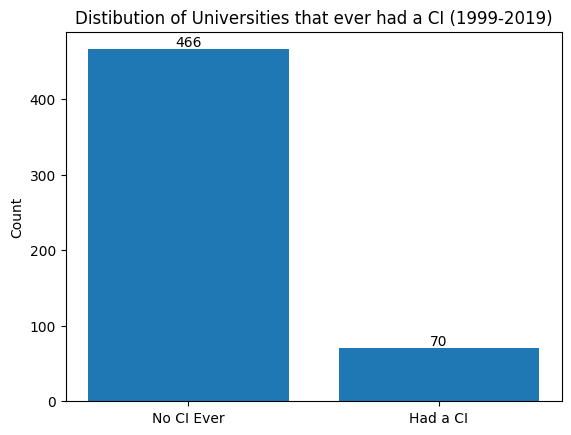

In [58]:
# start doing descriptive statistics based on Christine's requests

# descriptive Stats

# Number of schools 

from matplotlib import pyplot as plt


len(initial_data['university_state'].unique())


initial_data[initial_data['CI_open']==1]['university_state'].unique()



# Number of schools by CI ever

bar_df = survival_df_clean.groupby('CI_ever').count().reset_index()

bar_df = bar_df.rename(columns={"university_state": "Number of Schools"})



bar_df['CI_ever'] = bar_df['CI_ever'].map({0: 'No CI Ever', 1: 'Had a CI'})


x = bar_df['CI_ever']
y = bar_df['Number of Schools']

fig, ax = plt.subplots()
bars = ax.bar(x, y)

ax.bar_label(bars)

plt.ylabel("Count")



plt.title('Distibution of Universities that ever had a CI (1999-2019)')

fig.figure.savefig('CI_ever_bar.png', bbox_inches='tight')



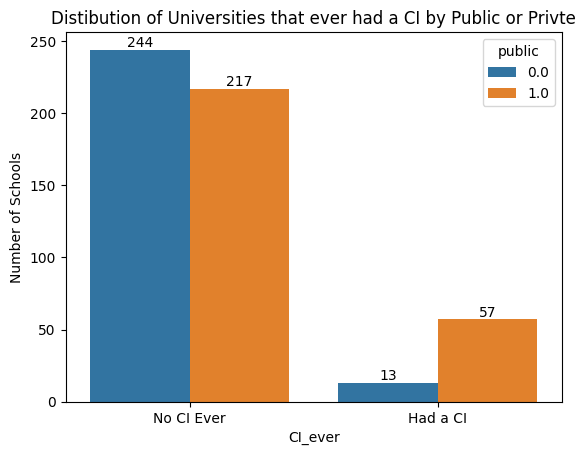

In [59]:

import seaborn as sns

bar_df = survival_df_clean


bar_df = bar_df.groupby(['CI_ever', 'public']).count().reset_index()



bar_df = bar_df.rename(columns={"university_state": "Number of Schools"})



bar_df['CI_ever'] = bar_df['CI_ever'].map({0: 'No CI Ever', 1: 'Had a CI'})


x = bar_df['CI_ever']
y = bar_df['Number of Schools']
color = bar_df['public']

ax = sns.barplot(data=bar_df, x=x, y=y, hue=color)


for i in ax.containers:
    ax.bar_label(i,)


plt.title('Distibution of Universities that ever had a CI by Public or Privte')






plt.savefig('CI_ever_pub_bar.png', bbox_inches='tight')


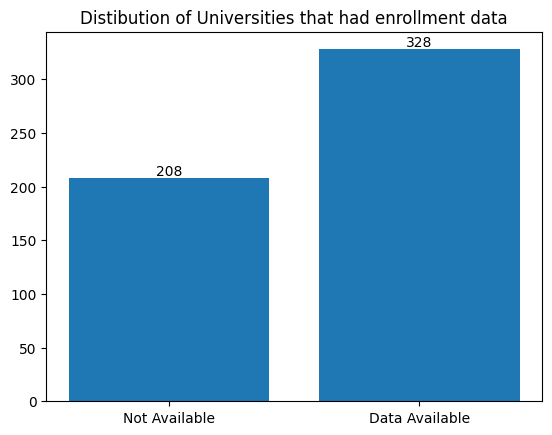

In [60]:
# enrollment summary stats


bar_df = survival_df_clean

bar_df['enrollment_available'] = np.where(bar_df['Enrollment'].isna(), 0, 1)



bar_df = bar_df.groupby('enrollment_available').count().reset_index()



bar_df = bar_df.rename(columns={"university_state": "Number of Schools"})



bar_df['enrollment_available'] = bar_df['enrollment_available'].map({0: 'Not Available', 1: 'Data Available'})


x = bar_df['enrollment_available']
y = bar_df['Number of Schools']

fig, ax = plt.subplots()
bars = ax.bar(x, y)

ax.bar_label(bars)




plt.title('Distibution of Universities that had enrollment data')

fig.figure.savefig('enrollment_avail_bar.png', bbox_inches='tight')

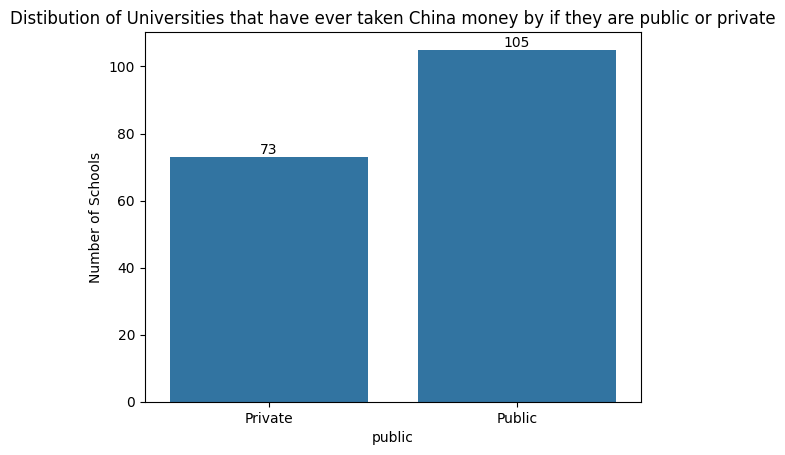

In [61]:
# enrollment summary stats


bar_df = survival_df_clean[survival_df_clean['all_year_china_donations']>0]



bar_df = bar_df.groupby(['public']).count().reset_index()



bar_df = bar_df.rename(columns={"university_state": "Number of Schools"})



bar_df['public'] = bar_df['public'].map({0: 'Private', 1: 'Public'})


x = bar_df['public']
y = bar_df['Number of Schools']

fig, ax = plt.subplots()

ax = sns.barplot(data=bar_df, x=x, y=y)

for i in ax.containers:
    ax.bar_label(i,)




plt.title('Distibution of Universities that have ever taken China money by if they are public or private')

fig.figure.savefig('china_money_pub_bar.png', bbox_inches='tight')

C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\2208822900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar_df['china_ever'] = np.where(bar_df['all_year_china_donations']>0, 1, 0)


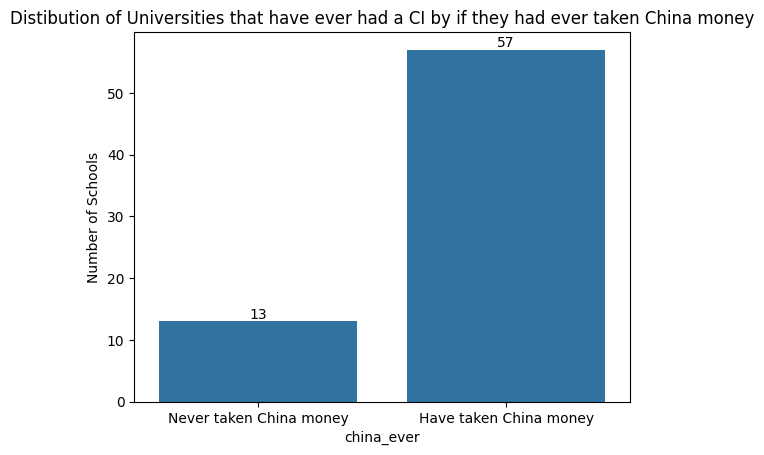

In [62]:
bar_df = survival_df_clean[survival_df_clean['CI_ever']==1]

bar_df['china_ever'] = np.where(bar_df['all_year_china_donations']>0, 1, 0)



bar_df = bar_df.groupby(['china_ever']).count().reset_index()



bar_df = bar_df.rename(columns={"university_state": "Number of Schools"})



bar_df['china_ever'] = bar_df['china_ever'].map({0: 'Never taken China money', 1: 'Have taken China money'})




x = bar_df['china_ever']
y = bar_df['Number of Schools']

fig, ax = plt.subplots()

ax = sns.barplot(data=bar_df, x=x, y=y)

for i in ax.containers:
    ax.bar_label(i,)




plt.title('Distibution of Universities that have ever had a CI by if they had ever taken China money')

fig.figure.savefig('CI_ever_China_money_bar.png', bbox_inches='tight')

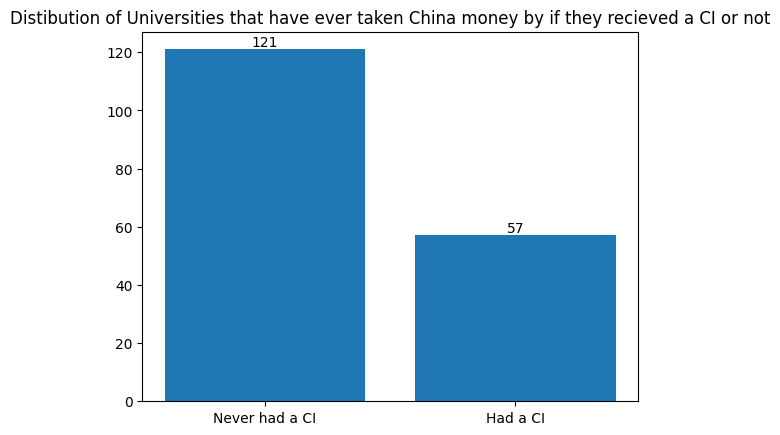

In [63]:
# enrollment summary stats


bar_df = survival_df_clean[survival_df_clean['all_year_china_donations']>0]



bar_df = bar_df.groupby('CI_ever').count().reset_index()



bar_df = bar_df.rename(columns={"university_state": "Number of Schools"})



bar_df['CI_ever'] = bar_df['CI_ever'].map({0: 'Never had a CI', 1: 'Had a CI'})


x = bar_df['CI_ever']
y = bar_df['Number of Schools']

fig, ax = plt.subplots()
bars = ax.bar(x, y)

ax.bar_label(bars)




plt.title('Distibution of Universities that have ever taken China money by if they recieved a CI or not')

fig.figure.savefig('china_money_CI_bar.png', bbox_inches='tight')


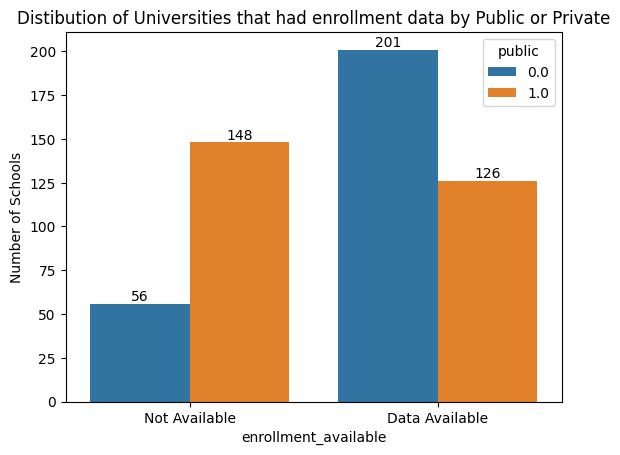

In [64]:
# check distribution of public/private schools missing enrollment data

import seaborn as sns

bar_df = survival_df_clean

bar_df['enrollment_available'] = np.where(bar_df['Enrollment'].isna(), 0, 1)



bar_df = bar_df.groupby(['enrollment_available', 'public']).count().reset_index()



bar_df = bar_df.rename(columns={"university_state": "Number of Schools"})



bar_df['enrollment_available'] = bar_df['enrollment_available'].map({0: 'Not Available', 1: 'Data Available'})


x = bar_df['enrollment_available']
y = bar_df['Number of Schools']
color = bar_df['public']

ax = sns.barplot(data=bar_df, x=x, y=y, hue=color)

for i in ax.containers:
    ax.bar_label(i,)



plt.title('Distibution of Universities that had enrollment data by Public or Private')






plt.savefig('enrollment_avail_pub_bar.png', bbox_inches='tight')


In [65]:
bar_df

,enrollment_available,public,Number of Schools,schoolname,state,Enrollment,year,CI_ever,No_CI_years,CI_opening,CI_survival_years,federal_share,total_china_donation,cumulative_china_donations,all_year_federal10,all_year_tot_rev_wo_auxother_sum,all_year_china_donations,all_year_foreign_donations,status
0,Not Available,0.0,56,56,56,0,56,56,56,56,2,9,56,56,56,56,56,56,56
1,Not Available,1.0,148,148,148,0,148,148,148,148,33,38,148,148,148,148,148,148,148
2,Data Available,0.0,201,201,201,201,201,201,201,201,11,173,201,201,201,201,201,201,201
3,Data Available,1.0,126,126,126,126,126,126,126,126,24,110,126,126,126,126,126,126,126


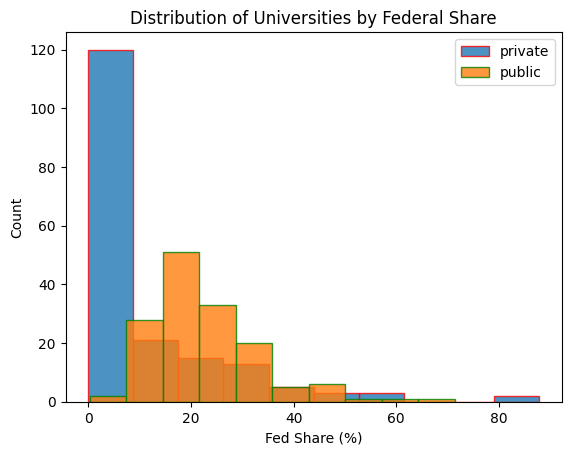

In [66]:
# do histograms for Fed Share and Chinese money summaries
from PIL import Image



hist = survival_df_clean

hist['public/private'] = hist['public'].map({0: 'private', 1: 'public'})

priv_group =  hist[hist['public']==0]['federal_share']*100

pub_group= hist[hist['public']==1]['federal_share']*100


fig, axs = plt.subplots()

plt.hist(priv_group, label='private', alpha=.8, edgecolor='red')


plt.hist(pub_group, label='public', alpha=.8, edgecolor='green')

#fig = plt.hist(plot, normed=0)


plt.legend()


plt.xlabel("Fed Share (%)")
plt.ylabel("Count")


plt.title('Distribution of Universities by Federal Share')

# Showing the plot using plt.show()
plt.show()

fig.figure.savefig('fed_share_hist.png', bbox_inches='tight')

In [67]:
survival_df

,university_state,schoolname,state,public,Enrollment,year,CI_ever,No_CI_years,CI_opening,CI_survival_years,federal_share,total_china_donation,cumulative_china_donations,all_year_federal10,all_year_tot_rev_wo_auxother_sum,all_year_china_donations,all_year_foreign_donations
0,Adelphi University_NY,Adelphi University,NY,0.0,7032.0,1995,0.0,1.0,NaN,NaN,0.010314,0.0,0.0,47388550.0,4.594392e+09,0.0,1000000.0
1,Adelphi University_NY,Adelphi University,NY,0.0,5968.0,1996,0.0,2.0,0.0,NaN,0.010314,0.0,0.0,47388550.0,4.594392e+09,0.0,1000000.0
2,Adelphi University_NY,Adelphi University,NY,0.0,5594.0,1997,0.0,3.0,0.0,NaN,0.010314,0.0,0.0,47388550.0,4.594392e+09,0.0,1000000.0
3,Adelphi University_NY,Adelphi University,NY,0.0,5806.0,1998,0.0,4.0,0.0,NaN,0.010314,0.0,0.0,47388550.0,4.594392e+09,0.0,1000000.0
4,Adelphi University_NY,Adelphi University,NY,0.0,5878.0,1999,0.0,5.0,0.0,NaN,0.010314,0.0,0.0,47388550.0,4.594392e+09,0.0,1000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15384,Young Americans College of the Performing Arts...,Young Americans College of the Performing Arts...,CA,0.0,NaN,2015,0.0,21.0,0.0,NaN,NaN,0.0,0.0,0.0,0.000000e+00,0.0,421583.0
15385,Young Americans College of the Performing Arts...,Young Americans College of the Performing Arts...,CA,0.0,NaN,2016,0.0,22.0,0.0,NaN,NaN,0.0,0.0,0.0,0.000000e+00,0.0,421583.0
15386,Young Americans College of the Performing Arts...,Young Americans College of the Performing Arts...,CA,0.0,NaN,2017,0.0,23.0,0.0,NaN,NaN,0.0,0.0,0.0,0.000000e+00,0.0,421583.0
15387,Young Americans College of the Performing Arts...,Young Americans College of the Performing Arts...,CA,0.0,NaN,2018,0.0,24.0,0.0,NaN,NaN,0.0,0.0,0.0,0.000000e+00,0.0,421583.0


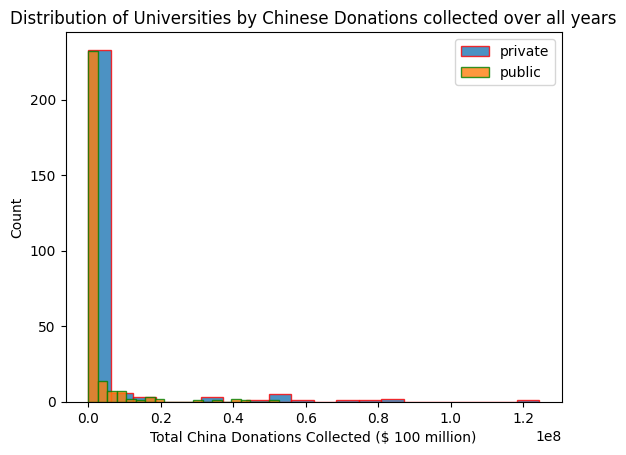

In [68]:
# do histograms for Fed Share and Chinese money summaries
from PIL import Image

# tryt 

hist = survival_df_clean


priv_group =  hist[hist['public']==0]['all_year_china_donations']

pub_group= hist[hist['public']==1]['all_year_china_donations']






fig, axs = plt.subplots()

plt.hist(priv_group, label='private', alpha=.8, edgecolor='red', bins=20)


plt.hist(pub_group, label='public', alpha=.8, edgecolor='green', bins=20)

#fig = plt.hist(plot, normed=0)


plt.legend()


plt.xlabel("Total China Donations Collected ($ 100 million)")
plt.ylabel("Count")


plt.title('Distribution of Universities by Chinese Donations collected over all years')

# Showing the plot using plt.show()
plt.show()

fig.figure.savefig('china_donation_hist.png', bbox_inches='tight')


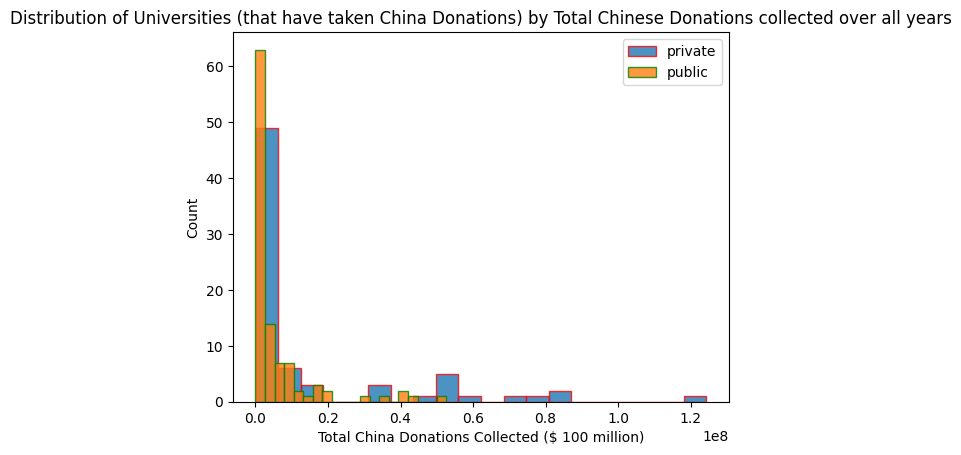

In [69]:
# do histograms for Fed Share and Chinese money summaries
from PIL import Image

# tryt 

hist = survival_df_clean[survival_df_clean['all_year_china_donations']>0]


priv_group =  hist[hist['public']==0]['all_year_china_donations']

pub_group= hist[hist['public']==1]['all_year_china_donations']






fig, axs = plt.subplots()

plt.hist(priv_group, label='private', alpha=.8, edgecolor='red', bins=20)


plt.hist(pub_group, label='public', alpha=.8, edgecolor='green', bins=20)

#fig = plt.hist(plot, normed=0)


plt.legend()


plt.xlabel("Total China Donations Collected ($ 100 million)")
plt.ylabel("Count")


plt.title('Distribution of Universities (that have taken China Donations) by Total Chinese Donations collected over all years')

# Showing the plot using plt.show()
plt.show()

fig.figure.savefig('china_donation_taken_hist.png', bbox_inches='tight')


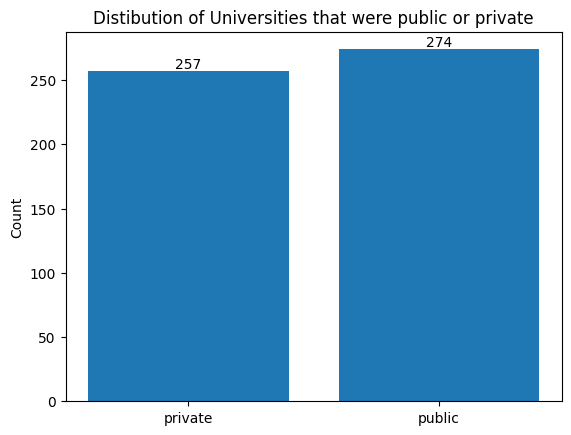

In [70]:
# Number of schools by Public Private 

bar_df = survival_df_clean.groupby('public').count().reset_index()

bar_df = bar_df.rename(columns={"university_state": "Number of Schools"})



bar_df['public/private'] = bar_df['public'].map({0: 'private', 1: 'public'})


x = bar_df['public/private']
y = bar_df['Number of Schools']

fig, ax = plt.subplots()
bars = ax.bar(x, y)

ax.bar_label(bars)



plt.ylabel("Count")


plt.title('Distibution of Universities that were public or private')

fig.figure.savefig('pub_priv_bar.png', bbox_inches='tight')


In [71]:
survival_df[survival_df['university_state']=='Alfred University_NY']


len(survival_df_clean)

536

In [98]:
china_donation_log_non_norm = []


non_normalized_df = survival_df


for i in non_normalized_df['total_china_donation']:
    if i !=0:
        china_donation_log_non_norm.append(math.log(i))
    else:
        i_mod = i+1
        china_donation_log_non_norm.append(math.log(i_mod))
        
non_normalized_df['china_donation_log_non_norm'] = china_donation_log_non_norm
ols = non_normalized_df

In [131]:
ols_CI = ols[ols['CI_ever']==1]

ols_no_CI = ols[ols['CI_ever']==0]

ols_public_CI = ols[(ols['CI_ever']==1)&(ols['public']==1) ]

ols_private_CI = ols[(ols['CI_ever']==1)&(ols['public']==0) ]



In [143]:
y_1 =ols['china_donation_log_non_norm']

x_1= ols[['year']]

x_1 = sm.add_constant(x_1)

result_CI = sm.OLS(y_1, x_1).fit()


y_2 =ols_no_CI['china_donation_log_non_norm']
x_2 = ols_no_CI[['year']]

x_2 = sm.add_constant(x_2)

result_no_CI = sm.OLS(y_2, x_2).fit()

y_3 =ols_public_CI['china_donation_log_non_norm']

x_3 = ols_public_CI[['year']]

x_3 = sm.add_constant(x_3)

result_pub_CI = sm.OLS(y_3, x_3).fit()



y_4 =ols_private_CI['china_donation_log_non_norm']

x_4 = ols_private_CI[['year']]

x_4 = sm.add_constant(x_4)

result_priv_CI = sm.OLS(y_4, x_4).fit()



stargazer = Stargazer([result_CI, result_no_CI, result_pub_CI, result_priv_CI])




HTML(stargazer.render_latex())

                                 OLS Regression Results                                
Dep. Variable:     china_donation_log_non_norm   R-squared:                       0.058
Model:                                     OLS   Adj. R-squared:                  0.058
Method:                          Least Squares   F-statistic:                     840.8
Date:                         Mon, 25 Mar 2024   Prob (F-statistic):          1.77e-179
Time:                                 13:59:56   Log-Likelihood:                -33935.
No. Observations:                        13750   AIC:                         6.787e+04
Df Residuals:                            13748   BIC:                         6.789e+04
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

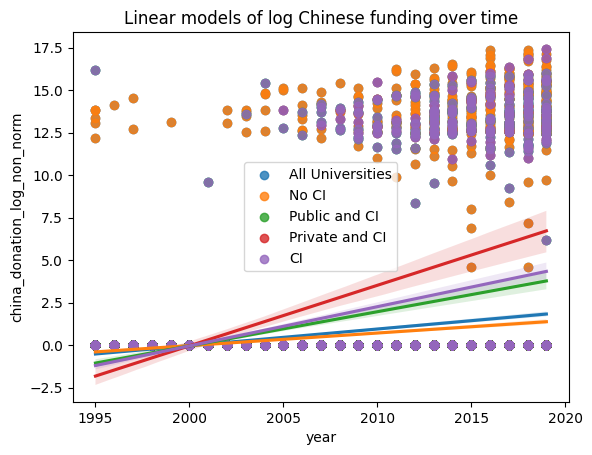

In [139]:
# OLS without interactions
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from IPython.core.display import HTML

 


stargazer = Stargazer([result_linear])

print(result_linear.summary())


HTML(stargazer.render_latex())

import seaborn as sns

ax = sns.regplot(x='year', y='china_donation_log_non_norm', order=1, label="All Universities", data=ols)

ax.legend(loc="best")


ax_no_CI = sns.regplot(x='year', y='china_donation_log_non_norm', order=1, label="No CI", data=ols_no_CI)

ax_no_CI.legend(loc="best")


ax_CI_pub = sns.regplot(x='year', y='china_donation_log_non_norm', order=1, label="Public and CI", data=ols_public_CI)

ax_CI_pub.legend(loc="best")


ax_CI_priv = sns.regplot(x='year', y='china_donation_log_non_norm', order=1, label="Private and CI", data=ols_private_CI)

ax_CI_priv.legend(loc="best")


ax_CI = sns.regplot(x='year', y='china_donation_log_non_norm', order=1, label="CI",  data=ols_CI)

ax_CI.legend(loc="best")

plt.title("Linear models of log Chinese funding over time")
plt.savefig('regressions.png')



# adding the constant term
# performing the regression
# and fitting the model
 
# printing the summary table

# make graphs from using pregrouped 

In [72]:


# do t0 analysis with total_china_donation statistic for one university first
import itertools



uni_names_filter= survival_df[survival_df['all_year_china_donations']>0]['university_state'].unique()


normalized_df = survival_df[(survival_df['CI_ever']==1)&(survival_df['university_state'].isin(uni_names_filter))]


uni_names = normalized_df['university_state'].unique()





# make number line based on CI_opening column

school_timeline_list = []

for i in uni_names:
    school_timeline = normalized_df[normalized_df['university_state']== i]
    No_CI_years = (school_timeline['No_CI_years']-school_timeline['No_CI_years'].max()-1).drop_duplicates()
    CI_years = school_timeline['CI_survival_years'].dropna()-1
    timeline = No_CI_years.append(CI_years).to_list()
    #school_timeline['timeline'] = timeline
    school_timeline_list.append(timeline)
    




school_timeline_clean = list(itertools.chain.from_iterable(school_timeline_list))


normalized_df['timeline'] = school_timeline_clean


C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\636521662.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timeline = No_CI_years.append(CI_years).to_list()
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\636521662.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timeline = No_CI_years.append(CI_years).to_list()
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\636521662.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timeline = No_CI_years.append(CI_years).to_list()
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\636521662.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timeline = No_CI_years.append(CI_y

In [73]:
uni_names_filter

uni_names_check= survival_df[survival_df['all_year_china_donations']>0]['university_state'].unique()


print(set(uni_names_check).difference(uni_names_filter))


survival_df[survival_df['university_state']=='Yale University_CT']

survival_df_clean[survival_df_clean['university_state']=='Arizona State University_AZ']

survival_df[survival_df['university_state']=='Arizona State University_AZ']


set()


,university_state,schoolname,state,public,Enrollment,year,CI_ever,No_CI_years,CI_opening,CI_survival_years,federal_share,total_china_donation,cumulative_china_donations,all_year_federal10,all_year_tot_rev_wo_auxother_sum,all_year_china_donations,all_year_foreign_donations
196,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,1995,1.0,1.0,0.0,NaN,0.238863,0.0,0.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
197,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,1996,1.0,2.0,0.0,NaN,0.238863,0.0,0.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
198,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,1997,1.0,3.0,0.0,NaN,0.238863,0.0,0.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
199,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,1998,1.0,4.0,0.0,NaN,0.238863,0.0,0.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
200,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,1999,1.0,5.0,0.0,NaN,0.238863,0.0,0.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
201,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,2000,1.0,6.0,0.0,NaN,0.238863,0.0,0.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
202,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,2001,1.0,7.0,0.0,NaN,0.238863,0.0,0.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
203,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,2002,1.0,8.0,0.0,NaN,0.238863,0.0,0.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
204,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,2003,1.0,9.0,0.0,NaN,0.238863,820000.0,820000.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0
205,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,2004,1.0,10.0,0.0,NaN,0.238863,0.0,820000.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0


Text(0, 0.5, 'Total Chinese donations in a year ($ million)')

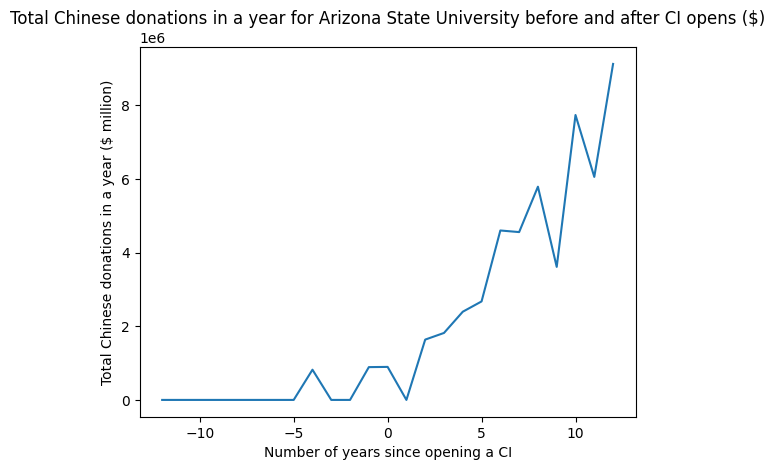

In [74]:
graph_test = normalized_df[normalized_df['university_state']== 'Arizona State University_AZ']

y = graph_test['total_china_donation']
x = graph_test['timeline']


# Create a line plot


plt.plot(x, y)


plt.title("Total Chinese donations in a year for " + graph_test['schoolname'].to_list()[1] + " before and after CI opens ($)")

plt.xlabel("Number of years since opening a CI")
plt.ylabel("Total Chinese donations in a year ($ million)")

# make graphs for each university with normalized data

In [75]:

for i in uni_names:
    graph_test = normalized_df[normalized_df['university_state']== i]
    y = graph_test['total_china_donation']
    x = graph_test['timeline']
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.scatter(x, y)
    plt.title("Total Chinese donations in a year for " + graph_test['schoolname'].to_list()[1] + " before and after CI opens")
    plt.xlabel("Number of years since opening a CI")
    plt.ylabel("Total Chinese donations in a year ($ million)")
    fig.savefig(graph_test['schoolname'].to_list()[1] + '_donation_CI.png', bbox_inches='tight')
    plt.close(fig)

In [76]:
china_donation_log = []


visualization_df = normalized_df
for i in normalized_df['total_china_donation']:
    if i !=0:
        china_donation_log.append(math.log(i))
    else:
        i_mod = i+1
        china_donation_log.append(math.log(i_mod))
        
visualization_df['china_donation_log'] = china_donation_log



C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\842384958.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visualization_df['china_donation_log'] = china_donation_log


In [97]:
# compile graphs for 57 schools 



# try combining all these lines into one figure

y = visualization_df['china_donation_log'] 
x = visualization_df['timeline']
c =visualization_df['university_state']
fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter(x, y)
plt.title("Log Chinese donations in a year for all schools within experimental set")
plt.xlabel("timeline")
plt.ylabel("Log Chinese donations in a year")





plt.xticks(rotation=45)

break_graph = sns.lineplot(x= x, y= y, hue = c)

ax.get_legend().set_visible(False)

break_graph.figure.savefig('timeline_graph.png', bbox_inches='tight')


KeyError: 'timeline'

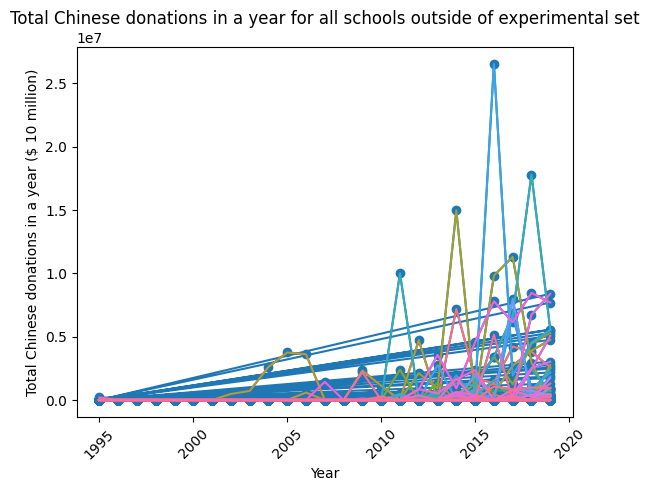

In [78]:
# do similar graph for all universities except the ones with a CI AND Chinese donations
# try with only public schools
break_df = survival_df[(survival_df['public']==1)&~((survival_df['all_year_china_donations']>0) & (survival_df['CI_ever']==1))]

break_names = break_df['university_state'].unique()

# try combining all these lines into one figure

y = break_df['total_china_donation']
x = break_df['year']
c =break_df['university_state']
fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter(x, y)
plt.title("Total Chinese donations in a year for all schools outside of experimental set")
plt.xlabel("Year")
plt.ylabel("Total Chinese donations in a year ($ 10 million)")





plt.xticks(rotation=45)

break_graph = sns.lineplot(x= x, y= y, hue = c)

ax.get_legend().set_visible(False)

break_graph.figure.savefig('break_graph.png', bbox_inches='tight')



In [79]:
survival_df



# validation
len(survival_df['university_state'].unique())-(len(break_names)+len(uni_names))

247

C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\788032944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ols_df_grouped['timeline_grouped'] = pd.cut(ols_df_grouped['timeline'], bins=6)
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\788032944.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ols_df_grouped['ma_china_donation'] = ols_df_grouped.groupby(['university_state','timeline_grouped'])['total_china_donation'].transform('mean')


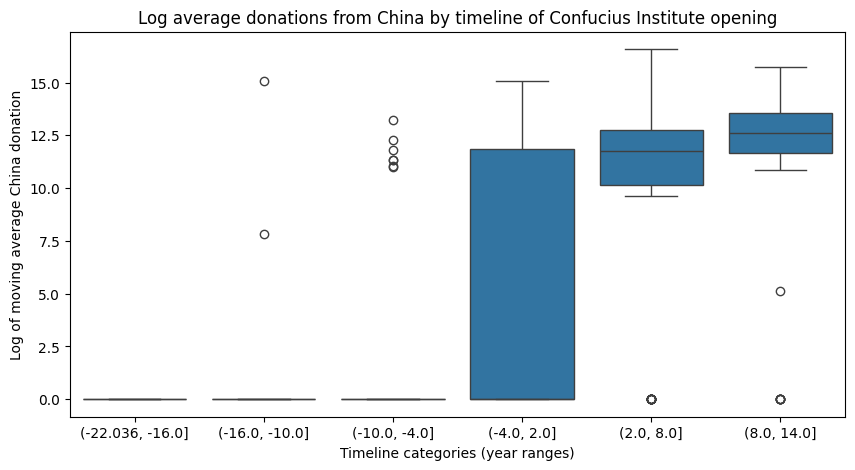

In [80]:
ols_df_grouped = normalized_df[['university_state','schoolname','state', 'year', 'public', 'federal_share', 'total_china_donation', 'timeline']]


ols_df_grouped['timeline_grouped'] = pd.cut(ols_df_grouped['timeline'], bins=6)

ols_df_grouped['ma_china_donation'] = ols_df_grouped.groupby(['university_state','timeline_grouped'])['total_china_donation'].transform('mean')




ols_df_grouped = ols_df_grouped.rename(columns={"timeline_grouped": "T_"})
ols_df_grouped = ols_df_grouped[['university_state','schoolname','state', 'year',  'public', 'federal_share', 'ma_china_donation', 'T_']]

# fix data grouping

ols_df_grouped[ols_df_grouped['university_state']=='Alfred University_NY']

ols_df_grouped = ols_df_grouped[['university_state','schoolname','state', 'public', 'federal_share', 'ma_china_donation', 'T_']]

ols_df_grouped = ols_df_grouped.drop_duplicates()

# make graph from using this data before dummies were created

china_donation_log = []


visualization_df = ols_df_grouped
for i in visualization_df['ma_china_donation']:
    if i !=0:
        china_donation_log.append(math.log(i))
    else:
        i_mod = i+1
        china_donation_log.append(math.log(i_mod))
        
visualization_df['china_donation_log'] = china_donation_log


plt.figure(figsize=[10, 5])




ax = sns.boxplot(x="T_",
                y="china_donation_log",
                data=visualization_df).set(xlabel ="Timeline categories (year ranges)", ylabel = 'Log of moving average China donation', title = "Log average donations from China by timeline of Confucius Institute opening")


plt.savefig("ols.png") 

ols_df_grouped = pd.get_dummies(ols_df_grouped, columns=['T_'],
               drop_first=True)


In [81]:
# summary stats tables for latex

from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from IPython.core.display import HTML
summary_df = survival_df_clean[['university_state','public', 'year', 'CI_ever', 'CI_survival_years', 'CI_opening', 'federal_share', 'all_year_china_donations','Enrollment' , 'enrollment_available']]
summary_df_china_ever = survival_df_clean[['university_state','public', 'year', 'CI_ever', 'CI_survival_years', 'CI_opening', 'federal_share','Enrollment' , 'enrollment_available', 'all_year_china_donations']]


# convert these tables into latex


# summary for public
summary_stats_pub = np.round(summary_df.groupby('public').describe(percentiles = []), 2).T

# summary for enroll

summary_stats_enroll = np.round(summary_df.groupby('enrollment_available').describe(percentiles = []), 2).T

# summary for enroll and public

summary_stats_enroll_pub = np.round(summary_df.groupby(['enrollment_available', 'public']).describe(percentiles = []), 2).T


# summary for CI ever 

summary_stats_CI_ever = np.round(summary_df.groupby('CI_ever').describe(percentiles = []), 2).T

# summary for CI ever and public

summary_stats_CI_pub = np.round(summary_df.groupby(['CI_ever', 'public']).describe(percentiles = []), 2).T


summary_df_china_ever['china_ever'] = np.where((summary_df_china_ever['all_year_china_donations']>0), 1, 0)


# summary for ever taken Chinese donation

summary_stats_china_ever = np.round(summary_df_china_ever.groupby('china_ever').describe(percentiles = []), 2).T



# summary for ever taken Chinese donation and public

summary_stats_china_pub = np.round(summary_df_china_ever.groupby(['china_ever', 'public']).describe(percentiles = []), 2).T






C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\1527557819.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df_china_ever['china_ever'] = np.where((summary_df_china_ever['all_year_china_donations']>0), 1, 0)


In [82]:



len(summary_df_china_ever[(summary_df_china_ever['china_ever']>0)&(summary_df_china_ever['CI_ever']==1)])

len(summary_df_china_ever[(summary_df_china_ever['china_ever']==1)&(summary_df_china_ever['CI_ever']==1)])


len(summary_df)


536

In [83]:
# summary stats tables for latex

from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from IPython.core.display import HTML
summary_df = survival_df_clean[['university_state','public', 'year', 'CI_ever', 'CI_survival_years', 'CI_opening', 'federal_share', 'all_year_china_donations','Enrollment' , 'enrollment_available']]
summary_df_china_ever = survival_df_clean[['university_state','public', 'year', 'CI_ever', 'CI_survival_years', 'CI_opening', 'federal_share','Enrollment' , 'enrollment_available', 'all_year_china_donations']]


# convert these tables into latex


# summary for public
summary_stats_pub = np.round(summary_df.groupby('public').describe(percentiles = []), 2).T

# summary for enroll

summary_stats_enroll = np.round(summary_df.groupby('enrollment_available').describe(percentiles = []), 2).T

# summary for enroll and public

summary_stats_enroll_pub = np.round(summary_df.groupby(['enrollment_available', 'public']).describe(percentiles = []), 2).T


# summary for CI ever 

summary_stats_CI_ever = np.round(summary_df.groupby('CI_ever').describe(percentiles = []), 2).T

# summary for CI ever and public

summary_stats_CI_pub = np.round(summary_df.groupby(['CI_ever', 'public']).describe(percentiles = []), 2).T


summary_df_china_ever['china_ever'] = np.where((summary_df_china_ever['all_year_china_donations']>0), 1, 0)


# summary for ever taken Chinese donation

summary_stats_china_ever = np.round(summary_df_china_ever.groupby('china_ever').describe(percentiles = []), 2).T



# summary for ever taken Chinese donation and public

summary_stats_china_pub = np.round(summary_df_china_ever.groupby(['china_ever', 'public']).describe(percentiles = []), 2).T






C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\1527557819.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df_china_ever['china_ever'] = np.where((summary_df_china_ever['all_year_china_donations']>0), 1, 0)


In [84]:


print('\section{Summary statistics for universities by public or private}')
print(summary_stats_pub.to_latex())

print('\section{Summary statistics for universities by which ones have enrollment data in our data set}')
print(summary_stats_enroll.to_latex())
print('\section{Summary statistics for universities by which ones have enrollment data in our data set separated by public and private}')

print(summary_stats_enroll_pub.to_latex())

print('\section{Summary statistics for universities by which ones have ever had a CI}')
print(summary_stats_CI_ever.to_latex())

print('\section{Summary statistics for universities by which ones have ever had a CI separated by public and private}')

print(summary_stats_CI_pub.to_latex())


# use long table
print('\section{Summary statistics for universities by which ones have ever taken China money}')
print(summary_stats_china_ever.to_latex())


# use long table

print('\section{Summary statistics for universities by ever having taken China money separated by public or private}')

print(summary_stats_china_pub.to_latex())



C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\414907254.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary_stats_pub.to_latex())
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\414907254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary_stats_enroll.to_latex())
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\414907254.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styl

\section{Summary statistics for universities by public or private}
\begin{tabular}{llrr}
\toprule
                     & public &           0.0 &          1.0 \\
\midrule
year & count &  2.570000e+02 &       274.00 \\
                     & mean &  2.018580e+03 &      2016.98 \\
                     & std &  1.890000e+00 &         4.17 \\
                     & min &  2.007000e+03 &      2005.00 \\
                     & 50\% &  2.019000e+03 &      2019.00 \\
                     & max &  2.019000e+03 &      2019.00 \\
CI\_ever & count &  2.570000e+02 &       274.00 \\
                     & mean &  5.000000e-02 &         0.21 \\
                     & std &  2.200000e-01 &         0.41 \\
                     & min &  0.000000e+00 &         0.00 \\
                     & 50\% &  0.000000e+00 &         0.00 \\
                     & max &  1.000000e+00 &         1.00 \\
CI\_survival\_years & count &  1.300000e+01 &        57.00 \\
                     & mean &  1.000000e+00 &         1

C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\414907254.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary_stats_CI_ever.to_latex())
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\414907254.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary_stats_CI_pub.to_latex())
C:\Users\casey\AppData\Local\Temp\2\ipykernel_8620\414907254.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation o

In [85]:
ma_china_donation_log = []

for i in ols_df_grouped['ma_china_donation']:
    if i !=0:
        ma_china_donation_log.append(math.log(i))
    else:
        i_mod = i+1
        ma_china_donation_log.append(math.log(i_mod))
        
ols_df_grouped['ma_china_donation_log'] = ma_china_donation_log

    

In [86]:
# OLS without interactions
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from IPython.core.display import HTML

 
y =ols_df_grouped['ma_china_donation_log']

x = ols_df_grouped[['public','T__(-16.0, -10.0]','T__(-10.0, -4.0]','T__(-4.0, 2.0]','T__(2.0, 8.0]','T__(8.0, 14.0]']]

x = sm.add_constant(x)



# adding the constant term
 
# performing the regression
# and fitting the model
result_1 = sm.OLS(y, x).fit()
 
# printing the summary table

# make graphs from using pregrouped 

In [87]:

# OLS with interactions

import statsmodels.api as sm

 
y =ols_df_grouped['ma_china_donation_log']

x = ols_df_grouped[['public','T__(-16.0, -10.0]','T__(-10.0, -4.0]','T__(-4.0, 2.0]','T__(2.0, 8.0]','T__(8.0, 14.0]']]

x = sm.add_constant(x)

x['int_1'] = x['public']*x['T__(2.0, 8.0]']
x['int_2'] = x['public']*x['T__(8.0, 14.0]']

# adding the constant term
 
# performing the regression
# and fitting the model
result_3 = sm.OLS(y, x).fit()
 


In [91]:

# Public OLS regression

import statsmodels.api as sm

data_pub = ols_df_grouped[ols_df_grouped['public']==1]
y =data_pub['ma_china_donation_log']
x = data_pub[['T__(-16.0, -10.0]','T__(-10.0, -4.0]','T__(-4.0, 2.0]','T__(2.0, 8.0]','T__(8.0, 14.0]']]

x = sm.add_constant(x)


# adding the constant term
 
# performing the regression
# and fitting the model
result_4 = sm.OLS(y, x).fit()
 


In [92]:

# Private OLS regression

import statsmodels.api as sm

data_priv = ols_df_grouped[ols_df_grouped['public']==0]
y =data_priv['ma_china_donation_log']
x = data_priv[['T__(-16.0, -10.0]','T__(-10.0, -4.0]','T__(-4.0, 2.0]','T__(2.0, 8.0]','T__(8.0, 14.0]']]

x = sm.add_constant(x)


# adding the constant term
 
# performing the regression
# and fitting the model
result_5 = sm.OLS(y, x).fit()
 





C:\Users\casey\AppData\Local\Temp\2\ipykernel_6404\1603975358.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ols_df_binary['timeline_sep'] = ols_df_binary['timeline'].apply(timeline_sep)
C:\Users\casey\AppData\Local\Temp\2\ipykernel_6404\1603975358.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ols_df_binary['ma_china_donation'] = ols_df_binary.groupby(['university_state','timeline_sep'])['total_china_donation'].transform('mean')
C:\Users\casey\AppData\Local\Temp\2\ipykernel_6404\1603975358.py:3

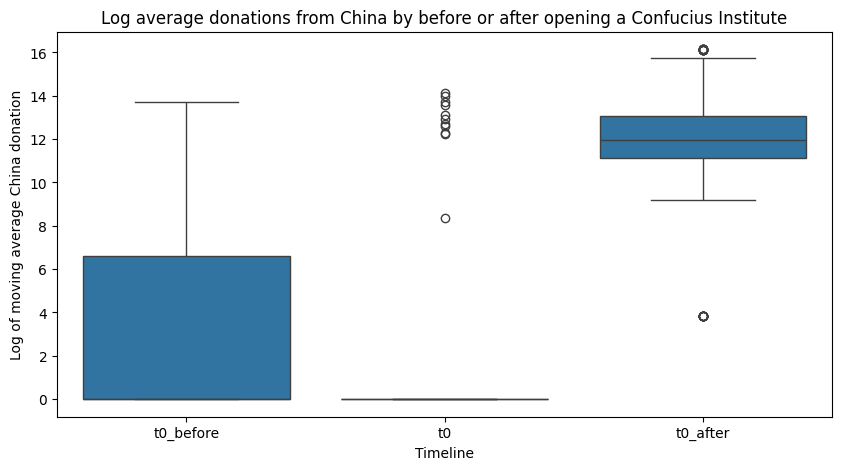

In [93]:
# remove duplicate rows form cross tab

import seaborn as sns


ols_df_binary = normalized_df[['university_state','schoolname','state', 'year', 'public', 'federal_share', 'total_china_donation', 'timeline']]

def timeline_sep(x):
    if 0 < x:
        return 't0_after'
    elif x==0:
        return 't0'
    else:
        return 't0_before'

    
ols_df_binary['timeline_sep'] = ols_df_binary['timeline'].apply(timeline_sep)




ols_df_binary['ma_china_donation'] = ols_df_binary.groupby(['university_state','timeline_sep'])['total_china_donation'].transform('mean')



ma_china_donation_log_bin = []

for i in ols_df_binary['ma_china_donation']:
    if i !=0:
        ma_china_donation_log_bin.append(math.log(i))
    else:
        i_mod = i+1
        ma_china_donation_log_bin.append(math.log(i_mod))
        
ols_df_binary['ma_china_donation_log'] = ma_china_donation_log_bin



ols_df_binary = ols_df_binary[['university_state','schoolname','state', 'year',  'public', 'federal_share', 'ma_china_donation_log', 'timeline_sep']]

# fix data grouping


ols_df_binary = ols_df_binary[['university_state','schoolname','state', 'public', 'federal_share', 'ma_china_donation_log', 'timeline_sep']]

plt.figure(figsize=[10, 5])


ax = sns.boxplot(x="timeline_sep",
                y="ma_china_donation_log",
                data=ols_df_binary).set(xlabel ="Timeline", ylabel = 'Log of moving average China donation', title = "Log average donations from China by before or after opening a Confucius Institute")


plt.savefig("ols_binary.png") 

ols_df_binary = pd.get_dummies(ols_df_binary, columns=['timeline_sep'],
               drop_first=True)




In [95]:
# Binary OLS regression
import statsmodels.api as sm

 
y = ols_df_binary[['ma_china_donation_log']]

x = ols_df_binary[['timeline_sep_t0_after']]


x['t0_after'] = x[['timeline_sep_t0_after']]

x = x['t0_after']
 
# adding the constant term
x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
result_2 = sm.OLS(y, x).fit()
 
# printing the summary table

stargazer = Stargazer([result_1, result_2, result_3, result_4, result_5])




HTML(stargazer.render_latex())


C:\Users\casey\AppData\Local\Temp\2\ipykernel_6404\647661333.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['t0_after'] = x[['timeline_sep_t0_after']]


In [ ]:
# make dummy variable with timeline
# pivot data wide with timeline variable

ols_df = normalized_df[['university_state','schoolname','state', 'year', 'public', 'federal_share', 'total_china_donation', 'timeline']]

ols_df = ols_df.rename(columns={"timeline": "index"})

ols_df = (
    pd.crosstab([ols_df["university_state"], ols_df["schoolname"], ols_df["state"], ols_df["year"], ols_df["public"],  ols_df["total_china_donation"]], ols_df["index"], )
    .gt(0)
    .astype(int)
    .reset_index()
)





ols_df.columns = [f'T_{i}' if i not in ['university_state','schoolname','state', 'year', 'public', 'federal_share', 'total_china_donation'] else f'{i}' for i in ols_df.columns]


# try grouping by column values to make groups
# calcualte moving average using grouped data
# try making dummy variable by if a variable is in a certain range of years ie., data in T-22, T_-21, T-19 or etc

In [232]:


#ols_df.columns[6:]


In [261]:
# modify this OLS code

import statsmodels.api as sm

 
y = ols_df[['total_china_donation']]/1000000

x = ols_df[['public', 'T_-22.0', 'T_-21.0', 'T_-20.0', 'T_-19.0', 'T_-18.0', 'T_-17.0',
       'T_-16.0', 'T_-15.0', 'T_-14.0', 'T_-13.0', 'T_-12.0', 'T_-11.0',
       'T_-10.0', 'T_-9.0', 'T_-8.0', 'T_-7.0', 'T_-6.0', 'T_-5.0', 'T_-4.0',
       'T_-3.0', 'T_-2.0', 'T_-1.0', 'T_0.0', 'T_1.0', 'T_2.0', 'T_3.0',
       'T_4.0', 'T_5.0', 'T_6.0', 'T_7.0', 'T_8.0', 'T_9.0', 'T_10.0',
       'T_11.0', 'T_12.0', 'T_13.0', 'T_14.0']]


 
# adding the constant term
x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()
 
# printing the summary table
print(result.summary())

                             OLS Regression Results                             
Dep. Variable:     total_china_donation   R-squared:                       0.079
Model:                              OLS   Adj. R-squared:                  0.054
Method:                   Least Squares   F-statistic:                     3.213
Date:                  Wed, 17 Jan 2024   Prob (F-statistic):           5.30e-10
Time:                          15:21:29   Log-Likelihood:                -2612.9
No. Observations:                  1425   AIC:                             5302.
Df Residuals:                      1387   BIC:                             5502.
Df Model:                            37                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6757      0.116

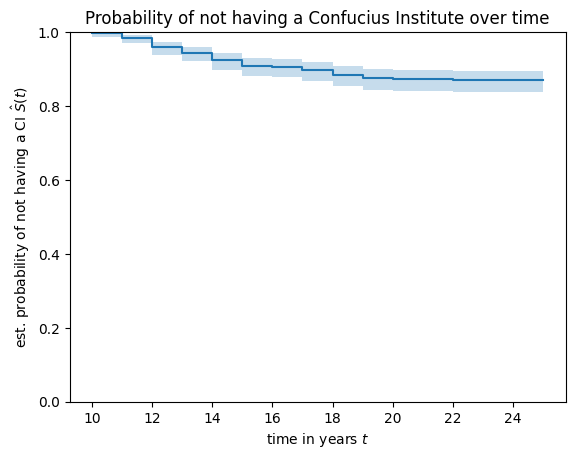

In [234]:
survival_df_clean = survival_df_clean.rename({'No_CI_years': 'survival_years'}, axis=1)



survival_df_clean['status'] = survival_df_clean['status'].astype('bool')




survival_df_clean

%matplotlib inline
import matplotlib.pyplot as plt

import sksurv

from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    survival_df_clean["status"], survival_df_clean["survival_years"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of not having a CI $\hat{S}(t)$")
plt.xlabel("time in years $t$")
plt.title('Probability of not having a Confucius Institute over time')


plt.savefig('CI_survival.png', bbox_inches='tight')



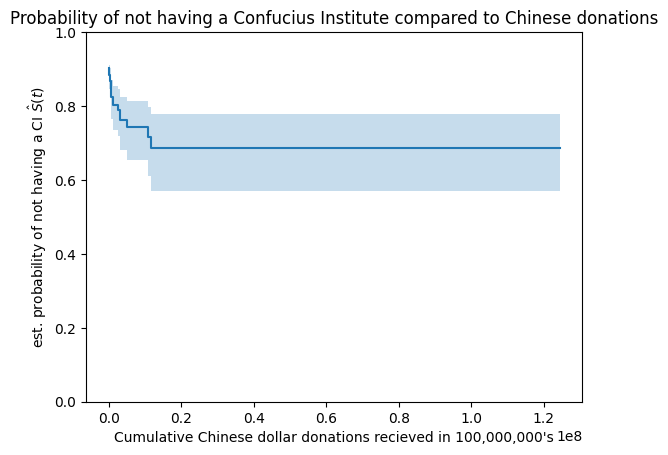

In [1073]:
#survival_df_clean['survival_odds'] = survival_df_clean['survival_years']/max(survival_df_clean['survival_years'])
survival_df_clean['CI_ever'] = survival_df_clean['CI_ever'].astype('bool')


china_donations = survival_df_clean[survival_df_clean['cumulative_china_donations'].notna()]



# try this https://stats.stackexchange.com/questions/496329/converting-survival-analysis-by-a-continuous-variable-to-categorical-so-as-to-fi
CI_ever, survival_prob, conf_int = kaplan_meier_estimator(
    china_donations["status"], china_donations["cumulative_china_donations"], conf_type="log-log"
)
plt.step(CI_ever, survival_prob, where="post")
plt.fill_between(CI_ever, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of not having a CI $\hat{S}(t)$")
plt.xlabel("Cumulative Chinese dollar donations recieved in 100,000,000's")
plt.title('Probability of not having a Confucius Institute compared to Chinese donations')

plt.savefig('chinese_donation_survival.png', bbox_inches='tight')



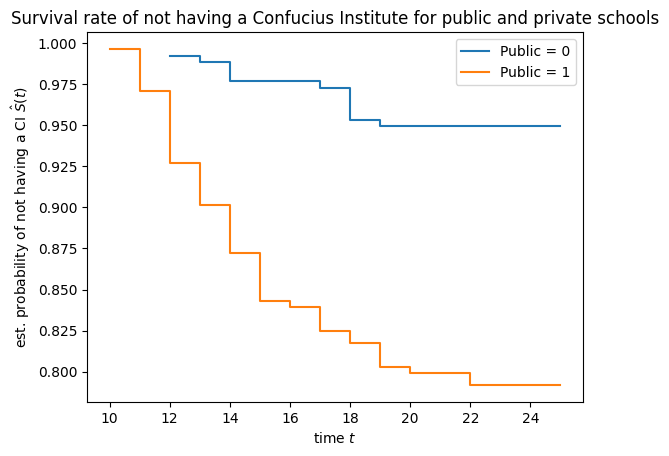

In [1074]:
# do this graph with Chinese donations on the X axis
# See what happens with Chinese donations once Confucius Institutes close
# Try clumping donation years together to deal with NaN values
# Has CI funding dropped a lot after CI closed?
# Has school relaunched Confucius Institutes with rebrand
# Check Katherine data to see which CI's survived but in different form

for public in (0, 1):
    mask_treat = survival_df_clean["public"] == public
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        survival_df_clean["CI_ever"][mask_treat],
        survival_df_clean["survival_years"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Public = %s" % public)

plt.ylabel("est. probability of not having a CI $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival rate of not having a Confucius Institute for public and private schools')
plt.legend(loc="best")

plt.savefig('pub_vs_priv_survival.png', bbox_inches='tight')


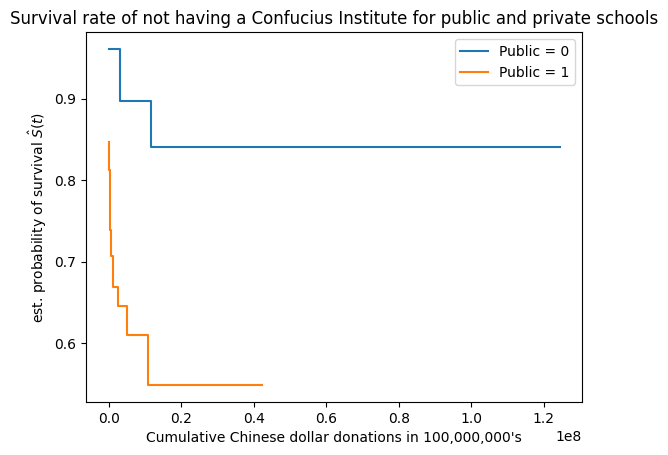

In [1075]:
# make new variable for cumulative China donations that stops once the University opens a Confucisus Institute
# use this new variable as a time scale


for public in (0, 1):
    mask_treat = survival_df_clean["public"] == public
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        survival_df_clean["status"][mask_treat],
        survival_df_clean["cumulative_china_donations"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Public = %s" % public)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("Cumulative Chinese dollar donations in 100,000,000's")
plt.title('Survival rate of not having a Confucius Institute for public and private schools')
plt.legend(loc="best")

plt.savefig('pub_vs_priv_money_survival.png', bbox_inches='tight')


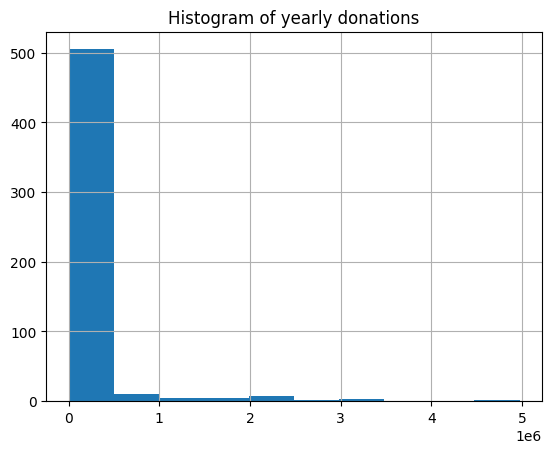

In [1076]:
survival_df_clean['avg_china_donations']= survival_df_clean['all_year_china_donations']/(2020-1995)
survival_df_clean['avg_china_donations'].hist()


plt.title('Histogram of yearly donations')

plt.savefig('donation_histogram.png', bbox_inches='tight')


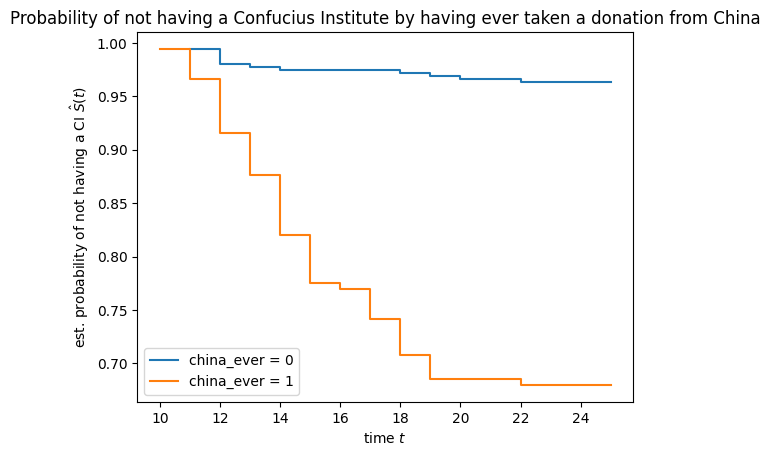

In [1077]:
# make survival grah with 0 being cutoff for Chinese donations
# make binary variable for china donation

survival_df_clean['china_ever'] = np.where(survival_df_clean['avg_china_donations'] > 0, 1, 0)


for china_ever in (0, 1):
    mask_treat = survival_df_clean["china_ever"] == china_ever
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        survival_df_clean["status"][mask_treat],
        survival_df_clean["survival_years"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="china_ever = %s" % china_ever)

plt.ylabel("est. probability of not having a CI $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Probability of not having a Confucius Institute by having ever taken a donation from China')
plt.legend(loc="best")

plt.savefig('china_donation_survival.png', bbox_inches='tight')



In [1078]:
# make graph where you groupby CI ever and not CI

# find mean closing year
# see how much donations change past mean closing year




master_df_enroll['CI_survival'] = master_df_enroll['CI_open'].diff()

master_df_enroll[master_df_enroll['schoolname']=='Arizona State University']



CI_close_year = master_df_clean[master_df_clean['CI_survival']==-1]

CI_close_year['CI_close_year']= 1

master_df_enroll= master_df_enroll.merge(CI_close_year, how = 'left')

master_df_enroll['CI_close_year']=  master_df_enroll['CI_close_year'].fillna(0)

# group by close year and find mean close year
# check how average donations change before and after mean close year


C:\Users\casey\AppData\Local\Temp\2\ipykernel_7176\1981849858.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CI_close_year['CI_close_year']= 1


In [1079]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from lifelines import CoxPHFitter


#split data into data_x and data_y 

survival_model = survival_df_clean.dropna()



# try binary version of donation vs non China donation for CI survival
# Look at overall distribution of funding and draw line for significant vs non-sihgnficant funding
# for every metric (average annual Chinese donation), check the distirbtuion with a histogram for Chinese donations
# use bottom point of histogram to see the cutoff to make two distinctive
# also figure out how to interpret Cox PH regression
# check distribution of public vs private universities in data set
# look up some literature on confucius institues in public vs private
# look at literature on Chinese influence in public vs private universties
# look at NAS studies on Confucius Institue work




In [1081]:
survival_model_public = survival_df_clean[survival_df_clean['public'].notna()]

cph = CoxPHFitter()
survival_years = cph.fit(survival_model_public, duration_col = 'survival_years', event_col = 'status', formula= "public + all_year_china_donations + all_year_foreign_donations")
cph.print_summary()


print('Being a public university increases the hazard for getting a CI by a factor of 4.42, or ',(4.42-1)*100,'%' )



<lifelines.CoxPHFitter: fitted with 531 total observations, 461 right-censored observations>
             duration col = 'survival_years'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 531
number of events observed = 70
   partial log-likelihood = -415.12
         time fit was run = 2024-01-09 15:38:08 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
public                       1.68       5.39       0.33             1.04             2.33                 2.83                10.25
all_year_china_donations     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
all_year_foreign_donations   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                             cmp to    z      p   -log2(p)
covariate                                                 
public                         0.00 5.14 <0.005      21.77
all_year_china_donations       0.00 1.67   0.09       3.41
all_year_foreign_donations     0.00 0.45   0.65       0.62
---
Concordance = 0.80
Partial AIC = 836.25
log-likelihood ratio test = 38.70 on 3 df
-log2(p) of ll-ratio test = 25.57

Being a public university increases the hazard for getting a CI by a factor of 4.42, or  342.0 %


In [1085]:
# install stargazer
from stargazer.stargazer import Stargazer

cph = CoxPHFitter()
survival_years = cph.fit(survival_model, duration_col = 'survival_years', event_col = 'status', formula= "public + all_year_federal10 + all_year_tot_rev_wo_auxother_sum+all_year_china_donations+all_year_foreign_donations")
cph.print_summary()


print('Being a public university increases the hazard for getting a CI by a factor of 4.19, or ',(4.19-1)*100,'%' )





<lifelines.CoxPHFitter: fitted with 35 total observations, 0 right-censored observations>
             duration col = 'survival_years'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 35
number of events observed = 35
   partial log-likelihood = -89.39
         time fit was run = 2024-01-09 15:38:30 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
public                             0.12       1.13       0.48            -0.82             1.06                 0.44                 2.87
all_year_federal10                 0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
all_year_tot_rev_wo_auxother_sum  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
all_year_china_donations           0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
all_year_foreign_donations        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                                   cmp to     z    p   -log2(p)
covariate                                                      
public                               0.00  0.25 0.80       0.32
all_year_federal10                   0.00  1.73 0.08       3.59
all_year_tot_rev_wo_auxother_sum     0.00 -1.16 0.24       2.03
all_year_china_donations             0.00  0.20 0.84       0.24
all_year_foreign_donations           0.00 -1.26 0.21       2.27
---
Concordance = 0.68
Partial AIC = 188.78
log-likelihood ratio test = 5.49 on 5 df
-log2(p) of ll-ratio test = 1.48

Being a public university increases the hazard for getting a CI by a factor of 4.19, or  319.00000000000006 %


In [1086]:

cph = CoxPHFitter()
donation_cph = cph.fit(survival_model, duration_col = 'cumulative_china_donations', event_col = 'status', formula= "public + all_year_federal10 + all_year_tot_rev_wo_auxother_sum+all_year_foreign_donations")
donation_cph.print_summary()


print('Being a public university increases the hazard for getting a CI as Chinese donation money increases by a factor of 3.68, or ',(3.68-1)*100,'%' )

<lifelines.CoxPHFitter: fitted with 35 total observations, 0 right-censored observations>
             duration col = 'cumulative_china_donations'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 35
number of events observed = 35
   partial log-likelihood = -84.01
         time fit was run = 2024-01-09 15:38:33 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
public                            -0.05       0.95       0.45            -0.94             0.84                 0.39                 2.32
all_year_federal10                 0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
all_year_tot_rev_wo_auxother_sum  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
all_year_foreign_donations        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                                   cmp to     z    p   -log2(p)
covariate                                                      
public                               0.00 -0.10 0.92       0.12
all_year_federal10                   0.00  1.14 0.26       1.97
all_year_tot_rev_wo_auxother_sum     0.00 -1.47 0.14       2.82
all_year_foreign_donations           0.00 -1.29 0.20       2.33
---
Concordance = 0.97
Partial AIC = 176.01
log-likelihood ratio test = 16.26 on 4 df
-log2(p) of ll-ratio test = 8.54

Being a public university increases the hazard for getting a CI as Chinese donation money increases by a factor of 3.68, or  268.0 %


,public,Number of Schools,school_type
0,0.0,257,private
1,1.0,274,public


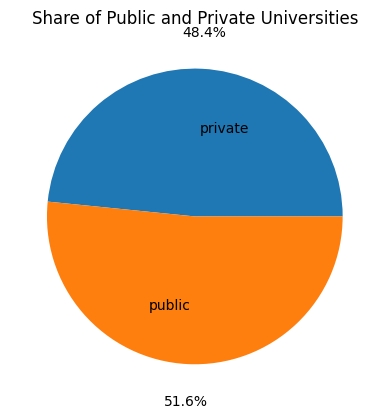

In [1087]:
pie_df = survival_df_clean.groupby('public').count().reset_index()

pie_df = pie_df[['public','university_state']]


pie_df = pie_df.rename(columns={"university_state": "Number of Schools"})



pie_df['school_type'] = pie_df['public'].map({0: 'private', 1: 'public'})


labels = pie_df['school_type']
sizes = pie_df['Number of Schools']




fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)

plt.title('Share of Public and Private Universities')

fig.figure.savefig('public_private_pie.png', bbox_inches='tight')

pie_df


,public,Number of Schools,school_type
0,0.0,13,private
1,1.0,57,public


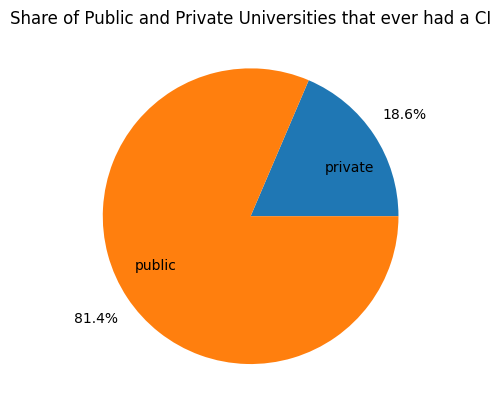

In [1088]:
CI_universities = survival_df_clean[survival_df_clean['CI_ever']==1]


pie_df = CI_universities.groupby('public').count().reset_index()

pie_df = pie_df[['public','university_state']]


pie_df = pie_df.rename(columns={"university_state": "Number of Schools"})



pie_df['school_type'] = pie_df['public'].map({0: 'private', 1: 'public'})


labels = pie_df['school_type']
sizes = pie_df['Number of Schools']




fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)

plt.title('Share of Public and Private Universities that ever had a CI')

fig.figure.savefig('public_private_CI_pie.png', bbox_inches='tight')

pie_df

,public,Number of Schools,school_type
0,0.0,61,private
1,1.0,60,public


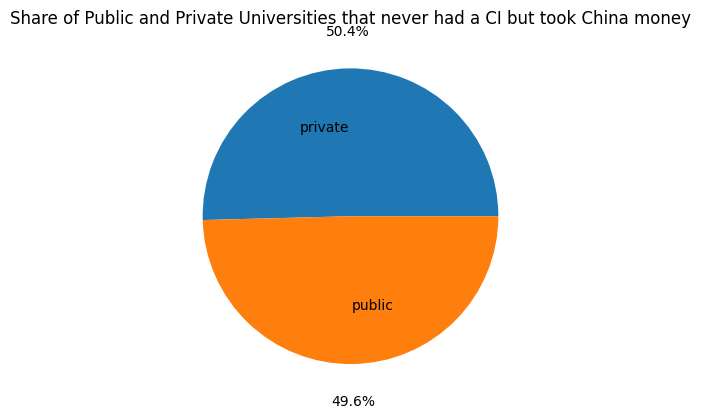

In [1089]:
No_CI_China = survival_df_clean.loc[(survival_df_clean['CI_ever'] == False) & (survival_df_clean['cumulative_china_donations'] >0)]




pie_df = No_CI_China.groupby('public').count().reset_index()

pie_df = pie_df[['public','university_state']]


pie_df = pie_df.rename(columns={"university_state": "Number of Schools"})



pie_df['school_type'] = pie_df['public'].map({0: 'private', 1: 'public'})


labels = pie_df['school_type']
sizes = pie_df['Number of Schools']




fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)

plt.title('Share of Public and Private Universities that never had a CI but took China money')

fig.figure.savefig('public_private_No_CI_China_pie.png', bbox_inches='tight')

pie_df



In [1090]:
No_CI_China['university_state'].unique()

array(['Albert Einstein College of Medicine_NY', 'Amherst College_MA',
       'Babson College_MA', 'Ball State University_IN',
       'Berkeley College_NY', 'Berklee College of Music_MA',
       'Boston College_MA', 'Boston University_MA',
       'Brigham Young University_UT', 'Brown University_RI',
       'California Institute of Technology_CA',
       'California State Polytechnic University, Pomona_CA',
       'California State University, Bakersfield_CA',
       'California State University, Fullerton_CA',
       'Carnegie Mellon University_PA',
       'Case Western Reserve University_OH', 'Chapman University_CA',
       'Colgate University_NY', 'Columbia College Chicago_IL',
       'Cornell College_IA', 'Cornell University_NY',
       "D'Youville College_NY", 'DePaul University_IL',
       'Duke University_NC', 'Eastern Washington University_WA',
       'Erikson Institute_IL', 'Florida International University_FL',
       'Fort Hays State University_KS', 'Frostburg State Universit

In [1091]:
pie_df

,public,Number of Schools,school_type
0,0.0,61,private
1,1.0,60,public


In [1092]:
survival_df_clean

,university_state,schoolname,state,public,Enrollment,year,CI_ever,survival_years,CI_opening,CI_survival_years,federal_share,total_china_donation,cumulative_china_donations,all_year_federal10,all_year_tot_rev_wo_auxother_sum,all_year_china_donations,all_year_foreign_donations,status,enrollment_available,public/private,avg_china_donations,china_ever
98,Alfred University_NY,Alfred University,NY,0.0,2319.0,2009,True,14.0,1.0,1.0,0.122902,0.0,0.0,1.302940e+08,1.060146e+09,541841.0,12967567.0,True,1,private,21673.64,1
208,Arizona State University_AZ,Arizona State University,AZ,1.0,NaN,2007,True,12.0,1.0,1.0,0.238863,896000.0,2606000.0,8.513125e+09,3.564025e+10,52573649.0,153510295.0,True,0,public,2102945.96,1
269,Auburn University Montgomery_AL,Auburn University Montgomery,AL,1.0,NaN,2012,True,17.0,1.0,1.0,0.144257,0.0,0.0,2.549890e+08,1.767600e+09,1752208.0,1752208.0,True,0,public,70088.32,1
798,Binghamton University_NY,Binghamton University,NY,1.0,14709.0,2009,True,14.0,1.0,1.0,0.146108,0.0,0.0,1.111916e+09,7.610215e+09,250000.0,250000.0,True,1,public,10000.00,1
1300,Bryant University_RI,Bryant University,RI,0.0,3733.0,2007,True,12.0,1.0,1.0,0.017398,0.0,0.0,3.777500e+07,2.171288e+09,4171367.0,4171367.0,True,1,private,166854.68,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15248,Worcester Polytechnic Institute_MA,Worcester Polytechnic Institute,MA,0.0,6894.0,2019,False,25.0,0.0,NaN,0.091782,0.0,0.0,3.189500e+08,3.475075e+09,0.0,1866477.0,False,1,private,0.00,0
15276,Wright State University_OH,Wright State University,OH,1.0,NaN,2019,False,25.0,0.0,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1693644.0,False,0,public,0.00,0
15332,Yale University_CT,Yale University,CT,0.0,13609.0,2019,False,25.0,0.0,NaN,0.344606,12516338.0,86136566.0,1.406534e+10,4.081576e+10,86136566.0,716274713.0,False,1,private,3445462.64,1
15360,Yeshiva University_NY,Yeshiva University,NY,0.0,5357.0,2019,False,25.0,0.0,NaN,0.282002,0.0,0.0,4.743446e+09,1.682060e+10,0.0,297897.0,False,1,private,0.00,0


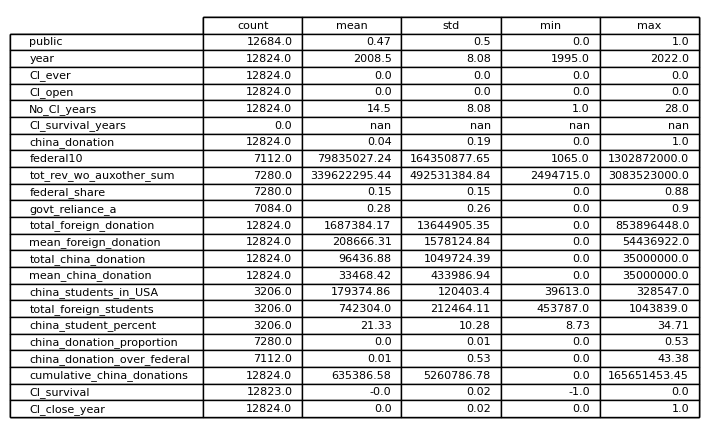

In [1093]:

summary_stats = np.round(master_df_clean.describe(), 2).T[['count','mean', 'std', 'min', 'max']]

summary_stats_CI = np.round(master_df_clean[master_df_clean['CI_ever'] == 1].describe(), 2).T[['count','mean', 'std', 'min', 'max']]


summary_stats_no_CI = np.round(master_df_clean[master_df_clean['CI_ever'] == 0].describe(), 2).T[['count','mean', 'std', 'min', 'max']]


CI_survival = survival_df_clean.loc[(survival_df_clean['CI_ever'] == True)]
    
    

summary_stats_survival = np.round(survival_df_clean.describe(), 2).T[['count','mean', 'std', 'min', 'max']]

CI_survival_summary = np.round(CI_survival.describe(), 2).T[['count','mean', 'std', 'min', 'max']]


No_CI_China_summary = np.round(No_CI_China.describe(), 2).T[['count','mean', 'std', 'min', 'max']]



descriptive_stats_list= [summary_stats, summary_stats_CI, summary_stats_no_CI]


descriptive_stats_names=  ['summary_stats', 'summary_stats_CI', 'summary_stats_no_CI']

import matplotlib.pyplot as plt
from pandas.plotting import table



for i, j in zip(descriptive_stats_list, descriptive_stats_names):
    plot = plt.subplot(111, frame_on=False)


    #remove axis
    plot.xaxis.set_visible(False) 
    plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
    table(plot, i, loc='upper right')
    plt.savefig(j +'.png', bbox_inches='tight')


In [1094]:
No_CI_survival = survival_df_clean.loc[(survival_df_clean['CI_ever'] == False)]
No_CI_survival_summary = np.round(No_CI_survival.describe(), 2).T[['count','mean', 'std', 'min', 'max']]


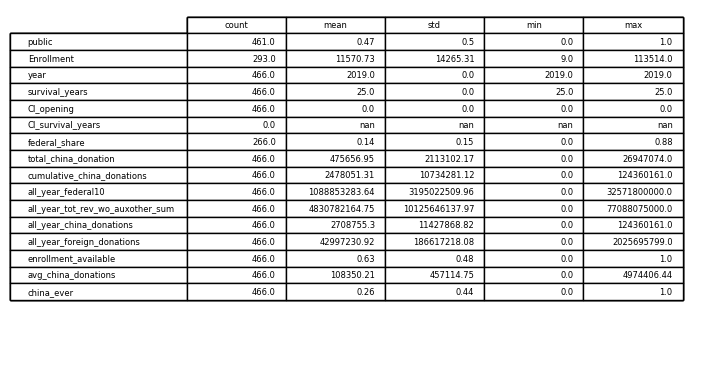

In [1095]:


descriptive_survival_list= [No_CI_China_summary, summary_stats_survival, CI_survival_summary, No_CI_survival_summary]


descriptive_survival_names=  ['No_CI_China_summary', 'summary_stats_survival', 'CI_survival_summary', 'No_CI_survival_summary']

import matplotlib.pyplot as plt
from pandas.plotting import table



for i, j in zip(descriptive_survival_list, descriptive_survival_names):
    plot = plt.subplot(111, frame_on=False)


    #remove axis
    plot.xaxis.set_visible(False) 
    plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
    table(plot, i, loc='upper right')
    plt.savefig(j +'.png', bbox_inches='tight')

In [1096]:
No_CI_survival_summary['CI_ever'].unique()

KeyError: 'CI_ever'

In [ ]:
# Graph output settings
import matplotlib.pyplot as plt




# put school name here
schoolname ="Arizona State University"

# put state code here

st = "AZ"

school_for_analysis = schoolname+'_'+st




year = 2006


master_df_clean[master_df_clean['schoolname']=='Arizona State University']


In [ ]:
example_graph = master_df_clean.groupby(['state'])['china_donation_over_federal'].mean().reset_index()

example_graph = example_graph.sort_values('china_donation_over_federal',ascending = False).head(10)

# filter this graph by top 5 states
x=example_graph['state']

y = example_graph['china_donation_over_federal']


plt.title('Top ten states that have the highest mean proportion of Chinese donations compared to federal funds')


plt.xticks(rotation=0, )

plt.tick_params(axis='x', which='major', labelsize=7)


example_donation_plot = sns.barplot(x= x, y= y)


example_donation_plot.figure.savefig('Chinese_donation_reliance_by_state.png', bbox_inches='tight')


# covert this data into a bar graph

master_df_clean[master_df_clean['total_foreign_donation']==0]

In [ ]:
example_graph = master_df_clean.groupby(['public', 'year'])['china_donation_over_federal'].mean().reset_index()

x=example_graph['year']

y = example_graph['china_donation_over_federal']
c =example_graph['public']

plt.title('Time series for public vs private proportion of Chinese donations to federal funds')


plt.xticks(rotation=45)


example_donation_plot = sns.barplot(x= x, y= y, hue= c)


example_donation_plot.figure.savefig('Chinese_donation_reliance.png', bbox_inches='tight')


# covert this data into a bar graph

In [ ]:
china_donation_2016 = master_df_clean[(master_df_clean['year']==2016)&(master_df_clean['public']==0)&(master_df_clean['china_donation'].notna())]

china_donation_2016.sort_values(by=['china_donation_over_federal'], ascending=False).head(10)

In [ ]:
# fix this pie chart!!
example_graph = master_df_clean.groupby(['public', 'CI_ever']).size().reset_index()


example_graph = example_graph.rename(columns = {0: 'count'})

x= example_graph['public']

y = example_graph['count']
c =example_graph['CI_ever']

CI_pub_plot = sns.barplot(x= x, y= y, hue= c)

plt.title('Number of public and private Universities that have ever had a CI')


CI_pub_plot.figure.savefig('CI_pub_plot.png', bbox_inches='tight')



In [ ]:


example_graph = master_df_clean[master_df_clean['university_state'].isin([school_for_analysis])]


x=example_graph['year']

y = example_graph['total_china_donation']
c =example_graph['CI_open']

plt.title('Time series for '+schoolname+' CI open years and Chinese donations')


plt.xticks(rotation=45)


example_donation_plot = sns.barplot(x= x, y= y, hue= c)


example_donation_plot.figure.savefig('example_donation_plot.png', bbox_inches='tight')



In [ ]:
import matplotlib.pyplot as plt

example_graph = master_df_clean[master_df_clean['university_state'].isin([school_for_analysis])]


x=example_graph['year']

y = example_graph['china_donation_over_federal']
c =example_graph['CI_open']

plt.title('Time series for '+schoolname+ ' CI open years and ratio of Chinese donations to Federal Funds')


plt.xticks(rotation=45)


example_donation_plot = sns.barplot(x= x, y= y, hue= c)

example_donation_plot.figure.savefig('school_ratio_federal_funds.png', bbox_inches='tight')



In [ ]:
len(master_df_clean[master_df_clean['r']=='R']['university_state'].unique())

In [ ]:
example_replacement =  master_df_clean[master_df_clean['r']=='R']['university_state'].unique()[21]




example_graph = master_df_clean[master_df_clean['university_state'].isin([example_replacement])]

replacement_name  = example_graph['schoolname'].unique()[0]


x=example_graph['year']

y = example_graph['total_china_donation']
c =example_graph['CI_close_year']
schools = example_graph['schoolname']

plt.title('Time series for '+replacement_name+ ' total Chinese donations with a mark when the CI closed')


plt.xticks(rotation=45)

example_donation_plot = sns.lineplot(x= x, y= y)


example_donation_plot = sns.scatterplot(x= x, y= y, hue= c, s = 100)


example_donation_plot.figure.savefig('CI_replaced_graph.png', bbox_inches='tight')




In [ ]:


example_graph = master_df_clean[master_df_clean['university_state'].isin([school_for_analysis])]


x=example_graph['year']

y = example_graph['total_china_donation']
c =example_graph['CI_close_year']
schools = example_graph['schoolname']

plt.title('Time series for '+schoolname+ ' total Chinese donations with a mark when the CI closed')


plt.xticks(rotation=45)

example_donation_plot = sns.lineplot(x= x, y= y, hue = schools) 


example_donation_plot = sns.scatterplot(x= x, y= y, hue= c, s = 100)


example_donation_plot.figure.savefig('CI_closed_graph.png', bbox_inches='tight') 




In [ ]:
example_graph = master_df_clean[master_df_clean['university_state'].isin([school_for_analysis])]

 
x=example_graph['year']

y = example_graph['CI_open']
c =example_graph['china_donation']

plt.title('Time series for '+schoolname+ ' CI open years and if they recieved Chinese donations that year')



plt.xticks(rotation=45)




example_CI_binary_plot = sns.scatterplot(x= x, y= y, hue= c)


example_CI_binary_plot.figure.savefig('example_CI_binary_plot.png', bbox_inches='tight')


In [ ]:
master_df_clean[master_df_clean['schoolname']=="Alabama A&M University"]

df[df['schoolname']=="Harvard University"]




df[df['schoolname']=="Harvard University"]

master_df_clean[master_df_clean['schoolname']=="Harvard University"]


df[(df['schoolname']=="Arizona State University") & (df['receipt_year']==1996)]

 

df[(df['schoolname']=="Arizona State University")]

master_df_clean[master_df_clean['schoolname']=="Stanford University"]


master_df_clean[master_df_clean['schoolname']== "Harvard University"]

In [ ]:
survival_df_clean.to_stata('CI_survival_data_cleaned.dta')  


master_df_clean.to_stata('school_year_data_cleaned.dta')  


In [ ]:
master_df_clean.dtypes

